# Processing

In [1]:
from pathlib import Path
import rasterio
import numpy as np
import xarray as xr
import os
import math
from xml.sax.saxutils import escape
import re
from typing import Dict, List
from rasterio.windows import Window
from rasterio.enums import Resampling
import random
from rasterio.io import MemoryFile
from rasterio.plot import show
from rasterio.warp import reproject, Resampling
from rioxarray.merge import merge_arrays
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from cdsapi import Client
import pandas as pd
import subprocess
import openpyxl
import rioxarray as rxr
from ftplib import FTP
import shutil
import gc
import geopandas as gpd

## Data Folder Structure

- data
  - LANDSAT
    - DAY
      - LC08_L1TP_{PATH}{ROW}_{YYYMMDD}

- Spatiotemporal
  - Datetime: 2020/01/02 - 2020/02/12

In [2]:
# Enable GDAL to use Py for Pixel Functions when calculating VRTs
os.environ["GDAL_VRT_ENABLE_PYTHON"] = "YES"

# Defines the root path
root = Path("data/LANDSAT")

# REGEX search for image bands with format: "_B{bnum}"
band_re = re.compile(r"_B(\d{1,2})(?=(_|\.))", re.IGNORECASE)

## Helpers

_scene_id_from_name_ checks if a filename matches the REGEX band search (band_re)

In [3]:
def scene_id_from_name(filename, debug = False):
    m = band_re.search(filename)
    if debug:
        print(f"Searching file: {filename}")
        if m:
            print(f"Found match with REGEX band search...")
            print(f"Match = {m.group(0)} at position {m.start()}-{m.end()}")
        else:
            print(f"No match with REGEX band search found!")
    return filename[:m.start()] if m else filename

In [6]:
# Examples
# 1. example showing one that works
test_path = "data/LANDSAT/DAY/LC08_L1TP_089083_20191106_20200825_02_T1/LC08_L1TP_089083_20191106_20200825_02_T1_B1.TIF"
scene_id_from_name(test_path, debug=True)

# 2. example showing failure
test_path = "data/LANDSAT/DAY/LC08_L1TP_089083_20191106_20200825_02_T1/LC08_L1TP_089083_20191106_20200825_02_T1_SZA.TIF"
scene_id_from_name(test_path, debug=True)


Searching file: data/LANDSAT/DAY/LC08_L1TP_089083_20191106_20200825_02_T1/LC08_L1TP_089083_20191106_20200825_02_T1_B1.TIF
Found match with REGEX band search...
Match = _B1 at position 98-101
Searching file: data/LANDSAT/DAY/LC08_L1TP_089083_20191106_20200825_02_T1/LC08_L1TP_089083_20191106_20200825_02_T1_SZA.TIF
No match with REGEX band search found!


'data/LANDSAT/DAY/LC08_L1TP_089083_20191106_20200825_02_T1/LC08_L1TP_089083_20191106_20200825_02_T1_SZA.TIF'

_collect_scenes_ searches the root data folder and finds matches

In [4]:
def collect_scenes(in_dir, debug = False):
    scenes = {}

    if debug:
        print(f"Searching input directory \"{in_dir}\" for files that match REGEX band search...")
    for tif in in_dir.rglob("*.TIF"):
        m = band_re.search(tif.name)
        if debug:
            print(f'{tif.name}: {"matched REGEX search for " + m.group(0) if m else "no match"}')
        if not m:
            continue
        b = int(m.group(1))
        sid = scene_id_from_name(tif.name)
        d = scenes.setdefault(sid, {})
        # prefer shorter filename if duplicates exist
        if b not in d or len(tif.name) < len(d[b].name):
            d[b] = tif
    return scenes

In [8]:
# Example
scenes = collect_scenes(root, debug = True)

Searching input directory "data\LANDSAT" for files that match REGEX band search...
DAY: no match
NIGHT: no match
LC08_L1TP_089083_20191106_20200825_02_T1: no match
LC08_L1TP_089083_20200109_20200823_02_T1: no match
LC08_L1TP_089083_20200125_20200823_02_T1: no match
LC08_L1TP_089084_20191106_20200825_02_T1: no match
LC08_L1TP_090083_20191113_20200825_02_T1: no match
LC08_L1TP_090083_20191215_20201022_02_T1: no match
LC08_L1TP_090083_20191231_20200824_02_T1: no match
LC08_L1TP_090083_20200201_20200823_02_T1: no match
LC08_L1TP_090083_20200217_20200823_02_T1: no match
LC08_L1TP_090084_20191113_20200825_02_T1: no match
LC08_L1TP_090084_20191215_20201022_02_T1: no match
LC08_L1TP_089083_20191106_20200825_02_T1_ANG.txt: no match
LC08_L1TP_089083_20191106_20200825_02_T1_ATM.nc: no match
LC08_L1TP_089083_20191106_20200825_02_T1_ATM_PROF.dat: no match
LC08_L1TP_089083_20191106_20200825_02_T1_B1.TIF: matched REGEX search for _B1
LC08_L1TP_089083_20191106_20200825_02_T1_B10.TIF: matched REGEX sea

## TOA Radiance Derivation

For bands B1-B11:

$$L_{\lambda} = M_L \times Q_{cal} + A_L$$

Where:
- $L_{\lambda}$ = spectral radiance (W/m^2 * sr * mircometers)
- $M_L$ = radiance multiplicative scaling factor for the band (RADIANCE_MULT_BAND_n from metadata)
- $A_L$ = radiance additive scaling factor for the for the band (RADIANCE_ADD_BAND_n from metadata)
- $Q_{cal}$ = level-1 pixel value in DN

In [9]:
wanted_bands = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [10]:
# Get RADIANCE scaling factors from metadata file (_MTL.txt)

def get_rad_scaling_factors(mtl_path):
    factors = {}
    with open(mtl_path) as f:
        for line in f:
            if "RADIANCE_MULT_BAND" in line or "RADIANCE_ADD_BAND" in line:
                key, val = line.strip().split(" = ")
                factors[key] = np.float32(val)
    return factors

In [11]:
# Define _RAD building VRT function
def build_radiance_vrt(src_tif, M_lambda, A_lambda, in_dtype = "UInt16", out_dtype = "Float32", in_band = 1, out_band = 1, nodata_in=0, nodata_out="nan"):
    import rasterio

    with rasterio.open(src_tif) as src:
        w, h = src.width, src.height
        transform = src.transform
        crs_wkt = src.crs.to_wkt() if src.crs else ""

    # Setup geotransform
    gt = f"{transform.c:.16g}, {transform.a:.16g}, {transform.b:.16g}, {transform.f:.16g}, {transform.d:.16g}, {transform.e:.16g}"

    # Load VRT template
    xml = Path("templates/rad.xml").read_text(encoding="utf-8")

    xml_mapping = {
      "width": w,
      "height": h,
      "crs_wkt": escape(crs_wkt),
      "in_dtype": in_dtype,
      "out_dtype": out_dtype,
      "geo_transform": gt,
      "in_band": in_band,
      "out_band": out_band,
      "src_filename": escape(src_tif.name),
      "nodata_in": nodata_in,
      "nodata_out": nodata_out,
      "M_lambda": f"{M_lambda:.10g}",
      "A_lambda": f"{A_lambda:.10g}"
    }

    # Map values to keys in VRT template
    for key, val in xml_mapping.items():
      xml = xml.replace(f"{{{{{key}}}}}", str(val))

    # Output built VRT
    out_vrt = src_tif.with_name(src_tif.stem + "_RAD.vrt")
    out_vrt.write_text(xml, encoding="utf-8")
    return out_vrt

In [12]:
# Loop and build _RAD vrts
for sid, bmap in sorted(scenes.items()):
    in_dir = next(iter(bmap.values())).parent

    print(f"The input image is: {in_dir}")

    # Locate the MTL file
    mtl_file = list(in_dir.glob("*_MTL.txt"))

    print(f"The MTL file is: {mtl_file}")
    
    if not mtl_file:
        print(f"No MTL found for {in_dir}")

    mtl_path = mtl_file[0]

    # Read MTL scale factors
    rad = get_rad_scaling_factors(mtl_path)

    # Search bands for scale factors
    for bnum in wanted_bands:
        band = str(bnum)

        src_tif = in_dir / f"{sid}_B{band}.TIF"
        out_vrt = in_dir / f"{sid}_B{band}_RAD.vrt"

        if not src_tif.exists():
            print(f"Skipping band {band}: {src_tif.name} not found")
            continue

        M_lambda = rad.get(f"RADIANCE_MULT_BAND_{band}")
        A_lambda = rad.get(f"RADIANCE_ADD_BAND_{band}")

        print(f"{out_vrt}: M_lambda={M_lambda}, A_lambda={A_lambda}")

        # Build VRT
        print("Building VRT...")
        build_radiance_vrt(src_tif, M_lambda = M_lambda, A_lambda = A_lambda)
        print("Complete!")

The input image is: data\LANDSAT\NIGHT\LC08_L1GT_208160_20191226_20200824_02_T2
The MTL file is: [WindowsPath('data/LANDSAT/NIGHT/LC08_L1GT_208160_20191226_20200824_02_T2/LC08_L1GT_208160_20191226_20200824_02_T2_MTL.txt')]
Skipping band 1: LC08_L1GT_208160_20191226_20200824_02_T2_B1.TIF not found
Skipping band 2: LC08_L1GT_208160_20191226_20200824_02_T2_B2.TIF not found
Skipping band 3: LC08_L1GT_208160_20191226_20200824_02_T2_B3.TIF not found
Skipping band 4: LC08_L1GT_208160_20191226_20200824_02_T2_B4.TIF not found
Skipping band 5: LC08_L1GT_208160_20191226_20200824_02_T2_B5.TIF not found
Skipping band 6: LC08_L1GT_208160_20191226_20200824_02_T2_B6.TIF not found
Skipping band 7: LC08_L1GT_208160_20191226_20200824_02_T2_B7.TIF not found
Skipping band 8: LC08_L1GT_208160_20191226_20200824_02_T2_B8.TIF not found
Skipping band 9: LC08_L1GT_208160_20191226_20200824_02_T2_B9.TIF not found
data\LANDSAT\NIGHT\LC08_L1GT_208160_20191226_20200824_02_T2\LC08_L1GT_208160_20191226_20200824_02_T2_B

In [13]:
# Picks a random DN pixel from the source and calculates manually then compares to derived values
test_src = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_B2.TIF"
test_rad = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_B2_RAD.vrt"

# From metadata MTL.text
M_lambda = 0.013087
A_lambda = -65.43689

with rasterio.open(test_src) as src, rasterio.open(test_rad) as rad:
    if (src.width != rad.width) or (src.height != rad.height):
        raise ValueError("Source and derived VRT dimensions differ")
    
    h, w = src.height, src.width

    r = random.randrange(h)
    c = random.randrange(w)

    dn = src.read(1, window=((r, r+1), (c, c+1))).astype(np.float32)[0, 0]
    rad_val = rad.read(1, window=((r, r+1), (c, c+1))).astype(np.float32)[0, 0]
    
    expected = M_lambda * dn + A_lambda

    diff = expected - rad_val

print(f"The value in the source tif is: {dn}")
print(f"The value in the derived vrt is: {rad_val}")
print(f"The expected value is: {expected}")
print(f"The difference is {diff}")

The value in the source tif is: 9101.0
The value in the derived vrt is: 53.66799545288086
The expected value is: 53.667896999999996
The difference is -9.845288086296478e-05


## TOA Reflectance Derivation (OLI)

For bands B1-B9:

$$\rho_{\lambda} = M_{\rho} \times Q_{cal} + A_{\rho}$$

Where:
- $\rho_{\lambda}'$ = TOA Planetary Spectral Reflectance without correction for solar angle (unitless)
- $M_{\rho}$ = reflectance multiplicative factor for the band (REFLECTANCE_MULT_BAND_n from the metadata)
- $A_{\rho}$ = reflectance additive scaling factor for the band (REFLECTANCE_ADD_BAND_N)
- $Q_{cal}$ = level 1 pixel DN value

Correction for sun elevation:

$$\rho_{\lambda}' = \frac{\rho_{\lambda}}{\sin{\theta_{SE}}}$$

In [14]:
wanted_bands = [1, 2, 3, 4, 5, 6, 7]
root = Path("data/LANDSAT/DAY") # Only need to do day
scenes = collect_scenes(root)

In [15]:
# Get reflectance factor
def get_refl_scaling_factors(mtl_path):
    factors = {}
    with open(mtl_path) as f:
        for line in f:
            if "REFLECTANCE_MULT_BAND" in line or "REFLECTANCE_ADD_BAND" in line:
                key, val = line.strip().split(" = ")
                factors[key] = np.float32(val)
    return factors

In [16]:
# Get sun elevation factor
def get_sun_elevation(mtl_path):
    with open(mtl_path) as f:
        for line in f:
            if "SUN_ELEVATION" in line:
                return float(line.strip().split(" = ")[1])
    return None

In [17]:
# Define _REFL building function
def build_reflectance_vrt(src_tif, M_rho, A_rho, sun_elev, in_dtype = "UInt16", out_dtype = "Float32", in_band = 1, out_band = 1, nodata_in=0, nodata_out="nan"):

    with rasterio.open(src_tif) as src:
        width, height = src.width, src.height
        transform = src.transform
        crs_wkt = src.crs.to_wkt() if src.crs else ""

    # Calculate angle-corrected REFL factors
        s = math.sin(math.radians(sun_elev))
        M_rho_prime = M_rho / s
        A_rho_prime = A_rho / s

    # Setup geotransform
    gt = f"{transform.c:.16g}, {transform.a:.16g}, {transform.b:.16g}, {transform.f:.16g}, {transform.d:.16g}, {transform.e:.16g}"
    

    # Load VRT template
    xml = Path("templates/refl.xml").read_text(encoding="utf-8")

    xml_mapping = {
        "width": width,
        "height": height,
        "crs_wkt": escape(crs_wkt),
        "in_dtype": in_dtype,
        "out_dtype": out_dtype,
        "geo_transform": gt,
        "in_band": in_band,
        "out_band": out_band,
        "src_filename": escape(src_tif.name),
        "nodata_in": nodata_in,
        "nodata_out": nodata_out,
        "M_rho": f"{M_rho_prime:.10g}",
        "A_rho": f"{A_rho_prime:.10g}",
    }

    # Map values to keys in VRT template
    for key, val in xml_mapping.items():
      xml = xml.replace(f"{{{{{key}}}}}", str(val))

    out_vrt = src_tif.with_name(src_tif.stem + "_REFL.vrt")
    out_vrt.write_text(xml, encoding="utf-8")
    return out_vrt

In [18]:
# Loop and build VRTs

for sid, bmap in sorted(scenes.items()):
    in_dir = next(iter(bmap.values())).parent

    print(f"The input image is: {in_dir}")

    # Locate the MTL file
    mtl_file = list(in_dir.glob("*_MTL.txt"))

    print(f"The MTL file is: {mtl_file}")
    
    if not mtl_file:
        print(f"No MTL found for {in_dir}")

    mtl_path = mtl_file[0]

    # Read MTL scale factors
    refl = get_refl_scaling_factors(mtl_path)
    sun_elev = get_sun_elevation(mtl_path)

    # Search bands for scale factors
    for bnum in wanted_bands:
        band = str(bnum)

        src_tif = in_dir / f"{sid}_B{band}.TIF"
        out_vrt = in_dir / f"{sid}_B{band}_REFL.vrt"

        M_rho = refl.get(f"REFLECTANCE_MULT_BAND_{band}")
        A_rho = refl.get(f"REFLECTANCE_ADD_BAND_{band}")

        print(f"{out_vrt}: M_rho={M_rho}, A_rho={A_rho}, SunElev={sun_elev}")

        # Build VRT
        print("Building...")
        build_reflectance_vrt(src_tif, M_rho, A_rho, sun_elev=sun_elev)
        print("Complete!")

The input image is: data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1
The MTL file is: [WindowsPath('data/LANDSAT/DAY/LC08_L1TP_089083_20191106_20200825_02_T1/LC08_L1TP_089083_20191106_20200825_02_T1_MTL.txt')]
data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_B1_REFL.vrt: M_rho=1.9999999494757503e-05, A_rho=-0.10000000149011612, SunElev=59.45657641
Building...
Complete!
data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_B2_REFL.vrt: M_rho=1.9999999494757503e-05, A_rho=-0.10000000149011612, SunElev=59.45657641
Building...
Complete!
data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_B3_REFL.vrt: M_rho=1.9999999494757503e-05, A_rho=-0.10000000149011612, SunElev=59.45657641
Building...
Complete!
data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_B4_REFL.vrt: M_rho=1.9999999494757503e-05, A_r

In [19]:
# Picks a random DN pixel from the source and calculates manually then compares to derived values
test_src = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_B2.TIF"
test_refl = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_B2_REFL.vrt"

# From metadata MTL.text
M_rho = 2e-05
A_rho = -0.1
sun_elev = 59.45657641

with rasterio.open(test_src) as src, rasterio.open(test_refl) as refl:
    if (src.width != refl.width) or (src.height != refl.height):
        raise ValueError("Source and derived VRT dimensions differ")
    
    h, w = src.height, src.width

    r = random.randrange(h)
    c = random.randrange(w)

    dn = src.read(1, window=((r, r+1), (c, c+1))).astype(np.float32)[0, 0]
    refl_val = refl.read(1, window=((r, r+1), (c, c+1))).astype(np.float32)[0, 0]
    
    rho_lambda = M_rho * dn + A_rho
    expected = rho_lambda / math.sin(math.radians(sun_elev))

print(f"The value in the source tif is: {dn}")
print(f"The value in the derived vrt is: {refl_val}")
print(f"The expected value is: {expected}")
print(f"The difference is {diff}")

The value in the source tif is: 9847.0
The value in the derived vrt is: 0.11255807429552078
The expected value is: 0.11255807995850328
The difference is -9.845288086296478e-05


## TOA Brightness Temperature (TIRS)

For bands B11 and B12:

$T = \frac{K_2}{\ln{\frac{K_1}{L_{\lambda}} + 1}}$

Where:
- $T$ = TOA Brightness Temp (K)
- $L_{\lambda}$ = TOA spectral radiance
- $K_1$ = Band-specific thermal conversion constant from the metadata (K1_CONSTANT_BAND_x, where x is the thermal band number)
- $K_2$ = Band-specific thermal conversion constant from the metadata (K2_CONSTANT_BAND_x, where x is the thermal band number)

In [20]:
wanted_bands = [10, 11]
root = Path("data/LANDSAT") # Do day and night
scenes = collect_scenes(root)

In [21]:
# Get K constants for brightness temp
def get_bt_factors(mtl_path):
    factors = {}
    with open(mtl_path) as f:
        for line in f:
            if "K1_CONSTANT_BAND" in line or "K2_CONSTANT_BAND" in line:
                key, val = line.strip().split(" = ")
                factors[key] = np.float32(val)
    return factors

In [22]:
# Define BT build VRT function
def build_bt_vrt(src_tif, M_lambda, A_lambda, K1, K2, in_dtype = "UInt16", out_dtype = "Float32", in_band = 1, out_band = 1, nodata_in=0, nodata_out=-9999.0):

    with rasterio.open(src_tif) as src:
        width, height = src.width, src.height
        transform = src.transform
        crs_wkt = src.crs.to_wkt() if src.crs else ""

    gt = f"{transform.c:.16g}, {transform.a:.16g}, {transform.b:.16g}, {transform.f:.16g}, {transform.d:.16g}, {transform.e:.16g}"

    xml_mapping = {
        "width": width,
        "height": height,
        "crs_wkt": escape(crs_wkt),
        "in_dtype": in_dtype,
        "out_dtype": out_dtype,
        "in_band": in_band,
        "out_band": out_band,
        "geo_transform": gt,
        "src_filename": escape(src_tif.name),
        "nodata_in": nodata_in,
        "nodata_out": nodata_out,
        "M_lambda": M_lambda,
        "A_lambda": A_lambda,
        "K1": K1,
        "K2": K2,
    }

    xml = Path("templates/bt.xml").read_text(encoding = "utf-8")

    for key, val in xml_mapping.items():
      xml = xml.replace(f"{{{{{key}}}}}", str(val))

    out_vrt = src_tif.with_name(src_tif.stem + "_BT.vrt")
    out_vrt.write_text(xml, encoding="utf-8")
    return out_vrt

In [23]:
# Build BT VRTS
for sid, bmap in sorted(scenes.items()):
    in_dir = next(iter(bmap.values())).parent

    print(f"The input image is: {in_dir}")

    # Locate MTL file
    mtl_file = list(in_dir.glob("*_MTL.txt"))
    
    if not mtl_file:
        print(f"No MTL found for {in_dir}")
    
    mtl_path = mtl_file[0]

    # Read MTL scale factors / constants
    rad = get_rad_scaling_factors(mtl_path)
    bt = get_bt_factors(mtl_path)

    # Search bands
    for bnum in wanted_bands:
        band = str(bnum)

        src_tif = in_dir / f"{sid}_B{band}.TIF"
        out_vrt = in_dir / f"{sid}_B{band}_BT.vrt"

        M_lambda = rad.get(f"RADIANCE_MULT_BAND_{band}")
        A_lambda = rad.get(f"RADIANCE_ADD_BAND_{band}")
        K1     = bt.get(f"K1_CONSTANT_BAND_{band}")
        K2     = bt.get(f"K2_CONSTANT_BAND_{band}")

        if M_lambda is None or A_lambda is None or K1 is None or K2 is None:
            print(f"Missing M_lambda/A_lambda/K1/K2 for B{band}; skipping.")
            continue
        
        print(f"{out_vrt}: M_lambdaL = {M_lambda}, A_lambda={A_lambda}, K1={K1}, K2={K2}")

        print(f"Building...")
        
        build_bt_vrt(src_tif, M_lambda = M_lambda, A_lambda=A_lambda, K1 = K1, K2 = K2)

        print(f"Complete!")

The input image is: data\LANDSAT\NIGHT\LC08_L1GT_208160_20191226_20200824_02_T2
data\LANDSAT\NIGHT\LC08_L1GT_208160_20191226_20200824_02_T2\LC08_L1GT_208160_20191226_20200824_02_T2_B10_BT.vrt: M_lambdaL = 0.00033420001273043454, A_lambda=0.10000000149011612, K1=774.8853149414062, K2=1321.078857421875
Building...
Complete!
data\LANDSAT\NIGHT\LC08_L1GT_208160_20191226_20200824_02_T2\LC08_L1GT_208160_20191226_20200824_02_T2_B11_BT.vrt: M_lambdaL = 0.00033420001273043454, A_lambda=0.10000000149011612, K1=480.8883056640625, K2=1201.1441650390625
Building...
Complete!
The input image is: data\LANDSAT\NIGHT\LC08_L1GT_208161_20191226_20200824_02_T2
data\LANDSAT\NIGHT\LC08_L1GT_208161_20191226_20200824_02_T2\LC08_L1GT_208161_20191226_20200824_02_T2_B10_BT.vrt: M_lambdaL = 0.00033420001273043454, A_lambda=0.10000000149011612, K1=774.8853149414062, K2=1321.078857421875
Building...
Complete!
data\LANDSAT\NIGHT\LC08_L1GT_208161_20191226_20200824_02_T2\LC08_L1GT_208161_20191226_20200824_02_T2_B11_BT

In [26]:
# Picks a random DN pixel from the source and calculates manually then compares to derived values
test_src = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_B10.TIF"
test_bt = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_B10_BT.vrt"

# From metadata MTL.text
M_L = 3.3420E-04
A_L = 0.10000
K1 = 774.8853
K2 = 1321.0789

with rasterio.open(test_src) as src, rasterio.open(test_bt) as bt:
    if (src.width != bt.width) or (src.height != bt.height):
        raise ValueError("Source and derived VRT dimensions differ")
    
    h, w = src.height, src.width

    r = random.randrange(h)
    c = random.randrange(w)

    dn = src.read(1, window=((r, r+1), (c, c+1))).astype(np.float32)[0, 0] # Band 1 in tif
    bt_val = bt.read(1, window=((r, r+1), (c, c+1))).astype(np.float32)[0, 0] # Band 3 in vrt
    
    L_lambda = M_L * dn + A_L
    expected = K2 / math.log((K1 / L_lambda) + 1)

    diff = expected - bt_val

print(f"The value in the source tif is: {dn}")
print(f"The value in the derived vrt is: {bt_val}")
print(f"The expected value is: {expected}")
print(f"The difference is {diff}")

The value in the source tif is: 0.0
The value in the derived vrt is: nan
The expected value is: 147.51709574377605
The difference is nan


# Night
Clear:
- LC08_L1GT_209161_20191217_20201023_02_T2
- LC08_L1GT_209161_20191115_20200825_02_T2
- LC08_L1GT_209160_20191217_20201023_02_T2
- LC08_L1GT_208160_20191226_20200824_02_T2
- LC08_L1GT_208161_20191226_20200824_02_T2

## Checkpoint
1. _RAD.vrts created for ALL bands
2. _REFL.vrt created for OLI bands
3. _BT.vrt created for TIRS bands

## Group single band _REFL.vrts into a multiband _TOA_REFL.vrt for each scene

In [27]:
wanted_bands = [2, 3, 4, 5, 6, 7]
root = Path('data/LANDSAT/DAY') # Only do day
scenes = collect_scenes(root)

In [28]:
def build_toa_refl_vrt(scene_id, bmap, out_vrt, refl_factors, sun_elev, wanted_bands, nodata_in = 0, nodata_out = "nan"):
    # Reference band for georef
    ref = bmap[min(bmap.keys())]

    with rasterio.open(ref) as src:
        w, h = src.width, src.height
        transform = src.transform
        crs_wkt = src.crs.to_wkt() if src.crs else ""
    gt = f"{transform.c:.16g}, {transform.a:.16g}, {transform.b:.16g}, {transform.f:.16g}, {transform.d:.16g}, {transform.e:.16g}"

    # Calculate sun elevation factor
    s = math.sin(math.radians(sun_elev))

    # Assemble per-band XML
    bands_xml = []
    out_idx = 1
    for b in wanted_bands:
        tif = bmap.get(b)
        M_rho = refl_factors.get(f"REFLECTANCE_MULT_BAND_{b}")
        A_rho = refl_factors.get(f"REFLECTANCE_ADD_BAND_{b}")

        M_rho_prime = M_rho / s
        A_rho_prime = A_rho / s

        # Load VRT template
        band_xml = Path("templates/band.xml").read_text(encoding="utf-8")

        # Map variables to VRT template
        band_xml_mapping = {
            "band_index": out_idx,
            "nodata_in": nodata_in,
            "nodata_out": nodata_out,
            "source_filename": escape(tif.name),
            "width" : w,
            "height": h,
            "out_idx": out_idx,
            "scale_ratio": f"{M_rho_prime:.10g}",
            "scale_offset": f"{A_rho_prime:.10g}"
        }
        
        for key, val in band_xml_mapping.items():
            band_xml = band_xml.replace(f"{{{{{key}}}}}", str(val))

        bands_xml.append(band_xml)
        out_idx += 1

    # Load master template
    master_xml = Path("templates/master.xml").read_text(encoding = "utf-8")

    # Add master components to .vrt XML
    master_xml_mapping = {
        "width": w,
        "height": h,
        "crs_wkt": escape(crs_wkt),
        "geo_transform": gt,
        "mask_xml": "",
        "bands_xml": "\n".join(bands_xml)
    }

    for key, val in master_xml_mapping.items():
        master_xml = master_xml.replace(f"{{{{{key}}}}}", str(val))
    
    out_vrt.write_text(master_xml, encoding="utf-8")
    print("→", out_vrt)

In [29]:
# Iterate through and construct a TOA_REFL vrt

for sid, bmap in sorted(scenes.items()):
    in_dir = bmap[min(bmap.keys())].parent
    out_vrt = in_dir / f"{sid}_TOA_REFL.vrt"

    # Locate MTL file
    mtl_file = list(in_dir.glob("*_MTL.txt"))

    if not mtl_file:
        print(f"No MTL found for {in_dir}")
    
    mtl_path = mtl_file[0]

    # Read MTL scale factors
    refl_factors = get_refl_scaling_factors(mtl_path)
    sun_elev = get_sun_elevation(mtl_path)

    build_toa_refl_vrt(scene_id=sid, bmap = bmap, out_vrt = out_vrt, refl_factors = refl_factors, sun_elev = sun_elev, wanted_bands = wanted_bands)

→ data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_TOA_REFL.vrt
→ data\LANDSAT\DAY\LC08_L1TP_089083_20200109_20200823_02_T1\LC08_L1TP_089083_20200109_20200823_02_T1_TOA_REFL.vrt
→ data\LANDSAT\DAY\LC08_L1TP_089083_20200125_20200823_02_T1\LC08_L1TP_089083_20200125_20200823_02_T1_TOA_REFL.vrt
→ data\LANDSAT\DAY\LC08_L1TP_089084_20191106_20200825_02_T1\LC08_L1TP_089084_20191106_20200825_02_T1_TOA_REFL.vrt
→ data\LANDSAT\DAY\LC08_L1TP_090083_20191113_20200825_02_T1\LC08_L1TP_090083_20191113_20200825_02_T1_TOA_REFL.vrt
→ data\LANDSAT\DAY\LC08_L1TP_090083_20191215_20201022_02_T1\LC08_L1TP_090083_20191215_20201022_02_T1_TOA_REFL.vrt
→ data\LANDSAT\DAY\LC08_L1TP_090083_20191231_20200824_02_T1\LC08_L1TP_090083_20191231_20200824_02_T1_TOA_REFL.vrt
→ data\LANDSAT\DAY\LC08_L1TP_090083_20200201_20200823_02_T1\LC08_L1TP_090083_20200201_20200823_02_T1_TOA_REFL.vrt
→ data\LANDSAT\DAY\LC08_L1TP_090083_20200217_20200823_02_T1\LC08_L1TP_090083_20200217_20

In [30]:
# Verify
test_src = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_B4.TIF" # Band 1 within the TIF
test_toa = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_TOA_REFL.vrt" # Band 3 within the VRT

M_rho = 2.0000E-05
A_rho = -0.1
sun_elev = 59.45657641

with rasterio.open(test_src) as src, rasterio.open(test_toa) as toa:
    if (src.width != toa.width) or (src.height != toa.height):
        raise ValueError("Source and derived VRT dimensions differ")
    
    h, w = src.height, src.width

    r = random.randrange(h)
    c = random.randrange(w)

    dn = src.read(1, window=((r, r+1), (c, c+1))).astype(np.float32)[0, 0] # Band 1 in tif
    toa_val = toa.read(3, window=((r, r+1), (c, c+1))).astype(np.float32)[0, 0] # Band 3 in vrt
    
    rho = M_rho * dn + A_rho
    rho_prime = rho / math.sin(math.radians(sun_elev))

    diff = rho_prime - toa_val

print(f"The value in the source tif is: {dn}")
print(f"The value in the derived vrt is: {toa_val}")
print(f"The expected value is: {rho_prime}")
print(f"The difference is {diff}")


The value in the source tif is: 8456.0
The value in the derived vrt is: 0.08025597035884857
The expected value is: 0.08025597778761862
The difference is 7.428770043560462e-09


## Valid Pixel Masking

- Valid Pixel Masking should be performed before darkest object subtraction to make sure cloud shadows are not influencing the darkest object 1% quantile
  - This is because a "VALID" darkest object is one that has intrinsically low reflectance, whereas cloud shadows are illumination artefact and can lead to overcorrection if included

### Criteria
- A common mask for Landsat 8 data is "clear" pixels:
  - Fill = 0 <!-- i.e is not NoData fill -->
  - Dilated cloud = 0
  - Cirrus = 0
  - Cloud = 0
  - Ice/Snow = 0
  - Cloud shadow = 0
  - Clear = 1
  - Cirrus conf < 1 <!-- Two-bit -->
  - Cloud conf < 1 <!-- Two-bit -->
  - Ice/snow conf < 1 <!-- Two-bit -->
  - Cloud shadow conf <1 <!-- Two-bit -->


### Sources
- https://github.com/mapbox/rio-l8qa
- “5.4 Unpacking Quality Assessment Band Bits” ([Zanter, 2016, p. 55](zotero://select/library/items/U5YN3SPF)) ([pdf](zotero://open-pdf/library/items/P2LF2YTN?page=63&annotation=TS5UTCRT))

QA data for Landsat is encoded in bit flags. Some flags are single-bit (0 = No, 1 = Yes). Others are two-bit fields (0 = Not set, 1 = Low, 2 = Medium, 3 = High). 

_bit_reader_ extracts them by shifting the integer raster right by the starting bit position and masking off the relevant bits.


### Helpers

In [31]:
def bit_reader(x, b, two_bit = False):
    if two_bit:
        return ((x >> b) & 0b11).astype(np.uint8)
    return((x >> b) & 1).astype(np.uint8)

NOTEs:
- No need to construct a VRT since a QA alpha mask will apply across the whole scene / all bands, and will be relatively small filesize
- Need to remove NaN padding for alpha mask...

### Build Mask TIF

In [32]:
def build_valid_mask(qa_pixel, out_tif, drop_water = False, debug = False):
    with rasterio.open(qa_pixel) as qpix_src:
        qpix = qpix_src.read(1).astype(np.uint16)
        profile = qpix_src.profile

    # Read QA bits
    if debug:
        print("Reading QA bits...")
    fill = bit_reader(qpix, 0) # Bit 0
    dcloud = bit_reader(qpix, 1) # Bit 1 
    cirrus = bit_reader(qpix, 2) # Bit 2
    cloud  = bit_reader(qpix, 3) # Bit 3
    shadow = bit_reader(qpix, 4) # Bit 4
    snow   = bit_reader(qpix, 5) # Bit 5
    clear = bit_reader(qpix, 6) # Bit 6
    water = bit_reader(qpix, 7) # Bit 7
    cloud_conf = bit_reader(qpix, 8, two_bit=True) # Bit 8-9
    cloud_shadow_conf = bit_reader(qpix, 10, two_bit=True) # Bit 10-11
    snow_conf = bit_reader(qpix, 12, two_bit=True) # Bit 12-13
    cirrus_conf = bit_reader(qpix, 14, two_bit=True) # Bit 14-15

    # Apply filters
    if debug:
        print("Applying filters for valid pixels...")
    valid = (
        (fill == 0) & # 0 = Not fill
        (dcloud == 0) & # 0 = No dilated cloud
        (cloud == 0) & # 0 = No cloud
        (shadow == 0) & # 0 = No cloud shadow
        (cirrus == 0) & # 0 = No cirrus
        (snow == 0) & # 0 = No snow
        (cloud_conf <= 1) & # 0 = Not set, 1 = Low, 2 = Med, 3 = High
        (cloud_shadow_conf <= 1) &
        (snow_conf <= 1) &
        (cirrus_conf <= 1)
    )

    # Optionally keep / drop water
    if drop_water:
        valid &= (water == 0)

    if debug is True:
        print(f"The total number of pixels is: {valid.size}")
        print(f"The toal number of clear pixels is {valid.sum()}")
        print(f"The percentage of clear pixels is:", float(valid.sum()) / float(valid.size) * 100, "%")

    # Make alpha mask for valid
    alpha = np.where(valid, 255, 0).astype(np.uint8)
    
    profile = profile.copy()
    profile.update(
        dtype = "uint8",
        count = 1,
    )

    # Write alpha mask
    with rasterio.open(out_tif, "w", **profile) as dest:
        dest.write(alpha, 1)
    if debug:
        print(f"Wrote alpha mask -> {out_tif}")
    
    return valid, alpha

In [33]:
root = Path('data/LANDSAT')
scenes = collect_scenes(root)

for sid, bmap in sorted(scenes.items()):
    in_dir = bmap[min(bmap.keys())].parent
    qa_pixel = in_dir / f"{sid}_QA_PIXEL.TIF" 
    out_tif = in_dir / f"{sid}_QA.TIF"
    build_valid_mask(qa_pixel = qa_pixel, out_tif = out_tif, drop_water = True, debug = True)

Reading QA bits...
Applying filters for valid pixels...
The total number of pixels is: 62030751
The toal number of clear pixels is 40944392
The percentage of clear pixels is: 66.00660372465909 %
Wrote alpha mask -> data\LANDSAT\NIGHT\LC08_L1GT_208160_20191226_20200824_02_T2\LC08_L1GT_208160_20191226_20200824_02_T2_QA.TIF
Reading QA bits...
Applying filters for valid pixels...
The total number of pixels is: 62030751
The toal number of clear pixels is 40918658
The percentage of clear pixels is: 65.9651178493712 %
Wrote alpha mask -> data\LANDSAT\NIGHT\LC08_L1GT_208161_20191226_20200824_02_T2\LC08_L1GT_208161_20191226_20200824_02_T2_QA.TIF
Reading QA bits...
Applying filters for valid pixels...
The total number of pixels is: 58766931
The toal number of clear pixels is 40974019
The percentage of clear pixels is: 69.72291780899702 %
Wrote alpha mask -> data\LANDSAT\NIGHT\LC08_L1GT_209160_20191217_20201023_02_T2\LC08_L1GT_209160_20191217_20201023_02_T2_QA.TIF
Reading QA bits...
Applying filt

## Surface Reflectance (OLI; Day)

- Using Dark Object Subtraction (DOS)
  - Simplest way to lessen effects of atmospheric scattering
  - Procedure that gets the darkest pixel values and subtracts them from the rest
  - Normalises images across time, allowing for the comparison of images under different atmospheric conditions

$$\rho_s = \rho_{TOA} - \rho_{haze}$$

Where:
- $\rho_s$ = surface reflectance
- $\rho_{TOA}$ = TOA surface reflectance
- $\rho_{haze}$ = reflectance value of the darkest objects
  - Generally slopes in complete shadow; sometimes deep water (though not sedimented water with high R/G reflectance!!)
  - Can be the minimum value, or a percentile (should be less than 1%)


[Chavez. 2014. *Re: What is the correct procedure for dark object subtraction?*](zotero://select/items/1_Y62JZNI9)

[Chavez. 1996. *Image-Based Atmospheric Corrections - Revisited and Improved*](zotero://select/items/1_BJ4MIJXS)

In [34]:
q = 0.01 # dark object quantile

### Helpers

In [35]:
def load_mask(m, debug = False):
    if isinstance(m, np.ndarray):
        out = m.astype(bool)
    else:
        with rasterio.open(m) as mask:
            out = (mask.read(1) != 0)
    if debug:
        size = out.size
        masked = int(out.sum())
        print(f"Masked {masked} ({masked/size*100:.2f}%) of {size} pixels")
    return out

In [36]:
def dos_quantile(src, band_index, q = 0.01, mask = None, skip_zero = True, nodata = np.nan, debug = False):
    if debug:
        print(f"Reading band {band_index} as float32")
    ds = src.read(band_index, out_dtype = "float32", masked = False)

    if mask is not None:
        if debug:
            print(f"Masking with {mask}")
        valid = load_mask(mask)
        ds = np.where(valid, ds, np.nan)

    v = ds.ravel()
    
    if skip_zero:
        if debug:
            n0 = np.count_nonzero(v == 0)
            print("Skip_zero = true...")
            print(f"Removing {n0} zeros")
        v = v[v != 0]

    if not np.isnan(nodata):
        if debug:
            n_nd = np.count_nonzero(v == nodata)
            print(f"Nodata = {nodata}...")
            print(f"Removing {n_nd} nodata matches")
        v = v[v != nodata]
    
    if debug:
        n_nan = np.count_nonzero(~np.isfinite(v))
        print(f"Remove {n_nan} non-finite matches")
    v = v[np.isfinite(v)]
    
    if v.size == 0:
        if debug:
            print("No valid samples -> returning NaN")
        return np.nan
    
    out = float(np.quantile(v, q))
    if debug:
        print(f"B{band}(q = {q}) = {out}")
    return out

#### Testing

In [37]:
# Test function with a known array
from rasterio.transform import from_origin

w, h = 5, 5
test = np.arange(w*h, dtype=np.float32).reshape((h, w))
test[1, 1] = 0.0

test_mask = np.ones((h, w), dtype=np.uint8)
test_mask[0:2, 0:2] = 0

flat = test.ravel()
expected_no_mask = float(np.quantile(flat[flat != 0], 0.2))

masked = np.where(test_mask.astype(bool), test, np.nan)
v = masked.ravel()
v = v[v != 0]
v = v[np.isfinite(v)]
expected_mask = float(np.quantile(v, 0.2))

transform = from_origin(0, 5, 1, 1)
with MemoryFile() as memory_file:
    with memory_file.open( driver= "GTiff", height = h, width = w, count = 1, dtype = "float32", transform = transform, crs = "EPSG:4326") as ds:
        ds.write(test, 1)

        r1 = dos_quantile(ds, 1, 0.2)
        r2 = dos_quantile(ds, 1, 0.2, mask = test_mask)

        d1 = abs(r1 - expected_no_mask)
        d2 = abs(r2 - expected_mask)

        print(f"dos_quantile (no mask) got: {r1:.6g}, expected: {expected_no_mask:.6g}, diff: {d1:.3g}")
        print(f"dos_quantile (w/ mask) got: {r2:.6g}, expected: {expected_mask:.6g}, diff: {d2:.3g}")

dos_quantile (no mask) got: 5.8, expected: 5.8, diff: 0
dos_quantile (w/ mask) got: 8, expected: 8, diff: 0


In [38]:
# Test on Landsat data
test_path = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_TOA_REFL.vrt"
test_mask = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_QA.TIF"
test_band = 3


with rasterio.open(test_path) as ds:
    q01 = dos_quantile(ds, band_index=test_band, q=0.01, mask=test_mask, debug=True)

Reading band 3 as float32
Masking with data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_QA.TIF
Skip_zero = true...
Removing 0 zeros
Remove 41188265 non-finite matches
B11(q = 0.01) = 0.04883631318807602


In [39]:
def compute_haze_for_all_bands(src, q=0.01, mask = None, skip_zero = True, nodata = np.nan, debug = False):
    haze_quantiles: list[float] = []
    if debug:
        print(f"Opening {src} with rasterio...")
    with rasterio.open(src) as ds:
        for b in range(1, ds.count +1):
            if debug:
                print(f"Computing haze for {b}...")
            haze = dos_quantile(ds, band_index = b, q = q, mask = mask, skip_zero = skip_zero, nodata = nodata, debug = False)
            haze = 0.0 if np.isnan(haze) else float(haze)
            haze_quantiles.append(haze)
            if debug:
                print(f"Haze is {haze}")
        return haze_quantiles

In [40]:
test_path = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_TOA_REFL.vrt"
test_mask = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_QA.TIF"

compute_haze_for_all_bands(src = test_path, q=0.01, mask = test_mask, debug= True)

Opening data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_TOA_REFL.vrt with rasterio...
Computing haze for 1...
Haze is 0.08548097312450409
Computing haze for 2...
Haze is 0.06504542380571365
Computing haze for 3...
Haze is 0.04883631318807602
Computing haze for 4...
Haze is 0.14825062453746796
Computing haze for 5...
Haze is 0.09198319166898727
Computing haze for 6...
Haze is 0.043332647532224655


[0.08548097312450409,
 0.06504542380571365,
 0.04883631318807602,
 0.14825062453746796,
 0.09198319166898727,
 0.043332647532224655]

### Build SR VRT

In [41]:
def build_sr_vrt(src, haze_quantiles, out_vrt, mask = None, out_dtype = "Float32", nodata_in = "0", nodata_out = "nan"):
    src = Path(src)
    out_vrt = Path(out_vrt)
    
    with rasterio.open(src) as ds:
        if len(haze_quantiles) != ds.count:
            raise ValueError(f"Number of haze-per-band values must match number of bands")
        
        h, w = ds.height, ds.width
        crs_wkt = ds.crs.to_wkt() if ds.crs else ""
        transform = ds.transform

    gt = f"{transform.c:.16g}, {transform.a:.16g}, {transform.b:.16g}, {transform.f:.16g}, {transform.d:.16g}, {transform.e:.16g}"
    
    if src.parent == out_vrt.parent:
        src_filename = escape(src.name)
        relative_to_vrt = "1"
    else:
        src_filename = escape(src.resolve().as_posix())
        relative_to_vrt = "0"

    bands_xml = []
    for i, haze in enumerate(haze_quantiles, start = 1):
    # Load VRT template
        band_xml = Path("templates/sr_band.xml").read_text(encoding="utf-8")
        # Map variables to VRT template
        band_xml_mapping = {
                "band_index": i,
                "source_band": i,
                "src_filename": src_filename,
                "relative_to_vrt": relative_to_vrt,
                "nodata_out": nodata_out,
                "nodata_in": nodata_in,
                "out_dtype": out_dtype,
                "width": w,
                "height": h,
                "scale_ratio": "1",
                "scale_offset": f"{-float(haze):.10g}",
            }
        
        for key, val in band_xml_mapping.items():
                band_xml = band_xml.replace(f"{{{{{key}}}}}", str(val))
        
        bands_xml.append(band_xml)
    
    mask_xml = ""
    if mask is not None:
        mask = Path(mask)
        if mask.parent == out_vrt.parent:
            mask_src = escape(mask.name); mask_rel = "1"
        else:
            mask_src = escape(mask.resolve().as_posix()); mask_rel = "0"
            # Load Mask VRT template
        mask_xml = Path("templates/mask.xml").read_text(encoding="utf-8")
        mask_xml = (
            mask_xml
            .replace("{{mask_src}}", mask_src)
            .replace("{{relative_to_vrt}}", mask_rel)
        )

    # Add master components to .vrt XML
    master_xml_mapping = {
        "width": w,
        "height": h,
        "crs_wkt": escape(crs_wkt),
        "geo_transform": gt,
        "mask_xml": mask_xml,
        "bands_xml": "\n".join(bands_xml)
    }

    master_xml = Path("templates/master.xml").read_text(encoding = "utf-8")
    for key, val in master_xml_mapping.items():
        master_xml = master_xml.replace(f"{{{{{key}}}}}", str(val))
    
    out_vrt.write_text(master_xml, encoding="utf-8")
    print("->", out_vrt)

In [47]:
# Iteratively build SR vrts for each scene
root = Path('data/LANDSAT/DAY')
scenes = collect_scenes(root)

for sid, bmap in sorted(scenes.items()):
    in_dir = bmap[min(bmap.keys())].parent
    toa_vrt = in_dir / f"{sid}_TOA_REFL.vrt"
    mask = in_dir / f"{sid}_QA.TIF"
    haze_quantiles = compute_haze_for_all_bands(src = toa_vrt, q = 0.01, mask = mask)
    out_vrt = in_dir / f"{sid}_SR.vrt"
    build_sr_vrt(src = toa_vrt, haze_quantiles = haze_quantiles, out_vrt = out_vrt, mask = mask)

-> data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_SR.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089083_20200109_20200823_02_T1\LC08_L1TP_089083_20200109_20200823_02_T1_SR.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089083_20200125_20200823_02_T1\LC08_L1TP_089083_20200125_20200823_02_T1_SR.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089084_20191106_20200825_02_T1\LC08_L1TP_089084_20191106_20200825_02_T1_SR.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191113_20200825_02_T1\LC08_L1TP_090083_20191113_20200825_02_T1_SR.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191215_20201022_02_T1\LC08_L1TP_090083_20191215_20201022_02_T1_SR.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191231_20200824_02_T1\LC08_L1TP_090083_20191231_20200824_02_T1_SR.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20200201_20200823_02_T1\LC08_L1TP_090083_20200201_20200823_02_T1_SR.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20200217_20200823_02_T1\LC08_L1TP_090083_20200217_20200823_02_T1_SR.vrt
-> data\LANDSAT\DAY

#### Testing

In [48]:
test_toa = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_TOA_REFL.vrt"
test_sr = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_SR.vrt"
test_mask = "data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_QA.TIF"
test_band = 3

In [49]:
haze_quantiles = compute_haze_for_all_bands(src=test_toa, mask = test_mask, debug=True)

Opening data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_TOA_REFL.vrt with rasterio...
Computing haze for 1...
Haze is 0.08548097312450409
Computing haze for 2...
Haze is 0.06504542380571365
Computing haze for 3...
Haze is 0.04883631318807602
Computing haze for 4...
Haze is 0.14825062453746796
Computing haze for 5...
Haze is 0.09198319166898727
Computing haze for 6...
Haze is 0.043332647532224655


In [50]:
print(f"The haze quantiles for each band, from the first on, are: {haze_quantiles}")
print(f"The selected bands for TOA_REFL and SR are bands {test_band}")
print(f"The darkest object subtraction quantile is: {haze_quantiles[test_band - 1]}")

The haze quantiles for each band, from the first on, are: [0.08548097312450409, 0.06504542380571365, 0.04883631318807602, 0.14825062453746796, 0.09198319166898727, 0.043332647532224655]
The selected bands for TOA_REFL and SR are bands 3
The darkest object subtraction quantile is: 0.04883631318807602


In [51]:
# Randomly tests a derived SR pixel against an expected result
with rasterio.open(test_toa) as toa, rasterio.open(test_sr) as sr:
    assert toa.count == sr.count == len(haze_quantiles), f"Band count mistmatch (TOA = {toa.count}, SR = {sr.count}, haze = {len(haze_quantiles)})"
    assert toa.width == sr.width and toa.height == sr.height, "Dimension mismatch"
    assert toa.transform == sr.transform, "Transform mismatch"
    assert toa.crs == sr.crs, "CRS mismatch"

    h, w = toa.height, toa.width
    
    r = random.randrange(h)
    c = random.randrange(w)

    toa_val = toa.read(test_band, window=((r, r+1), (c, c+1))).astype(np.float32)[0, 0]
    sr_val = sr.read(test_band, window=((r, r+1), (c, c+1))).astype(np.float32)[0, 0]

    expected = toa_val - haze_quantiles[test_band - 1]

    diff = expected - sr_val

print(f"The randomised test pixel is: {r} * {c}")
print(f"The TOA_REFL value for this pixel is : {toa_val}")
print(f"The SR value for this pixel is: {sr_val}")
print(f"The expected SR value for this pixel is: {expected}")
print(f"The difference between expected and returned is: {diff}")


The randomised test pixel is: 2779 * 690
The TOA_REFL value for this pixel is : -0.11611107736825943
The SR value for this pixel is: -0.16494739055633545
The expected SR value for this pixel is: -0.16494739055633545
The difference between expected and returned is: 0.0


### Checkpoint
- SR VRTs
  - Corrected with DOS
  - Masked for cloud, snow, ice, etc

In [52]:
def vrt_to_tif(vrt, out_path, debug = False):
    with rasterio.open(vrt) as src:
        
        dtype = src.dtypes[0]
        
        if debug:
            print(f"Source VRT is {dtype} datatype...")
            print(f"Setting up metadata...")
        
        profile = {
            "driver": "GTiff",
            "tiled": True,
            "blockxsize": 256,
            "blockysize": 256,
            "height": src.height,
            "width": src.width,
            "count": src.count,
            "dtype": dtype,
            "crs": src.crs,
            "transform": src.transform,
            "compress": "lzw",
            "nodata": src.nodata
        }

        if debug:
            print(f"Creating TIF...")
        with rasterio.open(out_path, "w", **profile) as dest:
            if debug:
                print("Transferring bands...")
            for i in range(1, src.count + 1):
                if debug:
                    print(f"Writing data from band {i}...")
                data = src.read(i)
                dest.write(data, i)

            if debug:
                print("Copying mask...")
            ds_mask = src.dataset_mask()
            if ds_mask is not None:
                dest.write_mask(ds_mask)

In [53]:
# for sid, bmap in sorted(scenes.items()):
#     in_dir = bmap[min(bmap.keys())].parent
#     sr_vrt = in_dir / f"{sid}_SR.vrt"
#     out_path = in_dir / f"{sid}_SR.tif"
#     vrt_to_tif(sr_vrt, out_path, debug = True)


## Compute NDVI

According to the equation:

$$ NDBI = \frac{NIR - VIS_R}{NIR + VIS_R} $$

NOTE: Bands 3 (Red) and 4 (NIR) in SR

In [54]:
def build_ndvi_vrt(src_sr, out_vrt, mask = None, out_band = 1, red_band = 3, nir_band = 4, out_dtype = "Float32", nodata_out = "nan", nodata_in = "nan"):
    src_sr = Path(src_sr)
    out_vrt = Path(out_vrt)

    with rasterio.open(src_sr) as src:
        w, h = src.width, src.height
        crs_wkt = src.crs.to_wkt() if src.crs else ""
        transform = src.transform

    gt = f"{transform.c:.16g}, {transform.a:.16g}, {transform.b:.16g}, {transform.f:.16g}, {transform.d:.16g}, {transform.e:.16g}"

    if src_sr.parent == out_vrt.parent:
        src_filename = escape(src_sr.name)
        relative_to_vrt = "1"
    else:
        src_filename = escape(src.resolve().as_posix())
        relative_to_vrt = "0"

    ndvi_xml = Path("templates/ndvi.xml").read_text(encoding = "utf-8")

    ndvi_mapping = {
        "width": w,
        "height": h,
        "out_dtype": out_dtype,
        "out_band": out_band,
        "crs_wkt": escape(crs_wkt),
        "geo_transform": gt,
        "nodata_out": nodata_out,
        "nodata_in": nodata_in,
        "nir_band": nir_band,
        "red_band": red_band,
        "relative_to_vrt": relative_to_vrt,
        "src_filename": src_filename,
    }

    for key, val in ndvi_mapping.items():
        ndvi_xml = ndvi_xml.replace(f"{{{{{key}}}}}", str(val))

    mask_xml = ""
    if mask is not None:
        mask = Path(mask)
        if mask.parent == out_vrt.parent:
            mask_src = escape(mask.name); mask_rel = "1"
        else:
            mask_src = escape(mask.resolve().as_posix()); mask_rel = "0"
            # Load Mask VRT template
        mask_xml = Path("templates/mask.xml").read_text(encoding="utf-8")
        mask_xml = (
            mask_xml
            .replace("{{mask_src}}", mask_src)
            .replace("{{relative_to_vrt}}", mask_rel)
        )

    master_xml = Path("templates/master.xml").read_text(encoding = "utf-8")

    master_xml_mapping = {
        "width": w,
        "height": h,
        "crs_wkt": escape(crs_wkt),
        "geo_transform": gt,
        "mask_xml": mask_xml,
        "bands_xml": ndvi_xml
    }

    for key, val in master_xml_mapping.items():
        master_xml = master_xml.replace(f"{{{{{key}}}}}", str(val))

    out_vrt.write_text(master_xml, encoding="utf-8")
    print("->", out_vrt)

In [55]:
for sid, bmap in sorted(scenes.items()):
    in_dir = bmap[min(bmap.keys())].parent
    src_sr = in_dir / f"{sid}_SR.vrt"
    out_vrt = in_dir / f"{sid}_NDVI.vrt"
    mask = in_dir / f"{sid}_QA.TIF"
    build_ndvi_vrt(src_sr= src_sr, out_vrt= out_vrt, mask = mask)

-> data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_NDVI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089083_20200109_20200823_02_T1\LC08_L1TP_089083_20200109_20200823_02_T1_NDVI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089083_20200125_20200823_02_T1\LC08_L1TP_089083_20200125_20200823_02_T1_NDVI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089084_20191106_20200825_02_T1\LC08_L1TP_089084_20191106_20200825_02_T1_NDVI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191113_20200825_02_T1\LC08_L1TP_090083_20191113_20200825_02_T1_NDVI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191215_20201022_02_T1\LC08_L1TP_090083_20191215_20201022_02_T1_NDVI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191231_20200824_02_T1\LC08_L1TP_090083_20191231_20200824_02_T1_NDVI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20200201_20200823_02_T1\LC08_L1TP_090083_20200201_20200823_02_T1_NDVI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20200217_20200823_02_T1\LC08_L1TP_090083_20200217_20200823_02_T1_NDVI.vrt
-

## Compute NDBI

According to the equation:

$$ NDBI = \frac{SWIR_1 - NIR}{SWIR_1 + NIR} $$

NOTE: Band 4 (NIR) and Band 5 (SWIR) in SR  

In [56]:
def build_ndbi_vrt(src_sr, out_vrt, mask = None, out_band = 1, swir1_band = 5, nir_band = 4, out_dtype = "Float32", nodata_out = "nan", nodata_in = "nan"):
    src_sr = Path(src_sr)
    out_vrt = Path(out_vrt)

    with rasterio.open(src_sr) as src:
        w, h = src.width, src.height
        crs_wkt = src.crs.to_wkt() if src.crs else ""
        transform = src.transform

    gt = f"{transform.c:.16g}, {transform.a:.16g}, {transform.b:.16g}, {transform.f:.16g}, {transform.d:.16g}, {transform.e:.16g}"

    if src_sr.parent == out_vrt.parent:
        src_filename = escape(src_sr.name)
        relative_to_vrt = "1"
    else:
        src_filename = escape(src.resolve().as_posix())
        relative_to_vrt = "0"

    ndbi_xml = Path("templates/ndbi.xml").read_text(encoding = "utf-8")

    ndbi_mapping = {
        "width": w,
        "height": h,
        "out_dtype": out_dtype,
        "out_band": out_band,
        "crs_wkt": escape(crs_wkt),
        "geo_transform": gt,
        "nodata_out": nodata_out,
        "nodata_in": nodata_in,
        "nir_band": nir_band,
        "swir1_band": swir1_band,
        "relative_to_vrt": relative_to_vrt,
        "src_filename": src_filename,
    }

    for key, val in ndbi_mapping.items():
        ndbi_xml = ndbi_xml.replace(f"{{{{{key}}}}}", str(val))

    mask_xml = ""
    if mask is not None:
        mask = Path(mask)
        if mask.parent == out_vrt.parent:
            mask_src = escape(mask.name); mask_rel = "1"
        else:
            mask_src = escape(mask.resolve().as_posix()); mask_rel = "0"
            # Load Mask VRT template
        mask_xml = Path("templates/mask.xml").read_text(encoding="utf-8")
        mask_xml = (
            mask_xml
            .replace("{{mask_src}}", mask_src)
            .replace("{{relative_to_vrt}}", mask_rel)
        )

    master_xml = Path("templates/master.xml").read_text(encoding = "utf-8")

    master_xml_mapping = {
        "width": w,
        "height": h,
        "crs_wkt": escape(crs_wkt),
        "geo_transform": gt,
        "mask_xml": mask_xml,
        "bands_xml": ndbi_xml
    }

    for key, val in master_xml_mapping.items():
        master_xml = master_xml.replace(f"{{{{{key}}}}}", str(val))

    out_vrt.write_text(master_xml, encoding="utf-8")
    print("->", out_vrt)

In [57]:
for sid, bmap in sorted(scenes.items()):
    in_dir = bmap[min(bmap.keys())].parent
    src_sr = in_dir / f"{sid}_SR.vrt"
    out_vrt = in_dir / f"{sid}_NDBI.vrt"
    mask = in_dir / f"{sid}_QA.TIF"
    build_ndbi_vrt(src_sr= src_sr, out_vrt= out_vrt, mask = mask)

-> data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_NDBI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089083_20200109_20200823_02_T1\LC08_L1TP_089083_20200109_20200823_02_T1_NDBI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089083_20200125_20200823_02_T1\LC08_L1TP_089083_20200125_20200823_02_T1_NDBI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089084_20191106_20200825_02_T1\LC08_L1TP_089084_20191106_20200825_02_T1_NDBI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191113_20200825_02_T1\LC08_L1TP_090083_20191113_20200825_02_T1_NDBI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191215_20201022_02_T1\LC08_L1TP_090083_20191215_20201022_02_T1_NDBI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191231_20200824_02_T1\LC08_L1TP_090083_20191231_20200824_02_T1_NDBI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20200201_20200823_02_T1\LC08_L1TP_090083_20200201_20200823_02_T1_NDBI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20200217_20200823_02_T1\LC08_L1TP_090083_20200217_20200823_02_T1_NDBI.vrt
-

## Compute NDWI

According to the equation:

$$ NDWI = \frac{VIS_G - NIR}{VIS_G + NIR} $$

NOTE: Band 2 (GREEN) and Band 4 (NIR) in SR

In [58]:
def build_ndwi_vrt(src_sr, out_vrt, mask = None, out_band = 1, green_band = 2, nir_band = 4, out_dtype = "Float32", nodata_out = "nan", nodata_in = "nan"):
    src_sr = Path(src_sr)
    out_vrt = Path(out_vrt)

    with rasterio.open(src_sr) as src:
        w, h = src.width, src.height
        crs_wkt = src.crs.to_wkt() if src.crs else ""
        transform = src.transform

    gt = f"{transform.c:.16g}, {transform.a:.16g}, {transform.b:.16g}, {transform.f:.16g}, {transform.d:.16g}, {transform.e:.16g}"

    if src_sr.parent == out_vrt.parent:
        src_filename = escape(src_sr.name)
        relative_to_vrt = "1"
    else:
        src_filename = escape(src.resolve().as_posix())
        relative_to_vrt = "0"

    ndwi_xml = Path("templates/ndwi.xml").read_text(encoding = "utf-8")

    ndwi_mapping = {
        "width": w,
        "height": h,
        "out_dtype": out_dtype,
        "out_band": out_band,
        "crs_wkt": escape(crs_wkt),
        "geo_transform": gt,
        "nodata_out": nodata_out,
        "nodata_in": nodata_in,
        "nir_band": nir_band,
        "green_band": green_band,
        "relative_to_vrt": relative_to_vrt,
        "src_filename": src_filename,
    }

    for key, val in ndwi_mapping.items():
        ndwi_xml = ndwi_xml.replace(f"{{{{{key}}}}}", str(val))

    mask_xml = ""
    if mask is not None:
        mask = Path(mask)
        if mask.parent == out_vrt.parent:
            mask_src = escape(mask.name); mask_rel = "1"
        else:
            mask_src = escape(mask.resolve().as_posix()); mask_rel = "0"
            # Load Mask VRT template
        mask_xml = Path("templates/mask.xml").read_text(encoding="utf-8")
        mask_xml = (
            mask_xml
            .replace("{{mask_src}}", mask_src)
            .replace("{{relative_to_vrt}}", mask_rel)
        )

    master_xml = Path("templates/master.xml").read_text(encoding = "utf-8")

    master_xml_mapping = {
        "width": w,
        "height": h,
        "crs_wkt": escape(crs_wkt),
        "geo_transform": gt,
        "mask_xml": mask_xml,
        "bands_xml": ndwi_xml
    }

    for key, val in master_xml_mapping.items():
        master_xml = master_xml.replace(f"{{{{{key}}}}}", str(val))

    out_vrt.write_text(master_xml, encoding="utf-8")
    print("->", out_vrt)

In [59]:
for sid, bmap in sorted(scenes.items()):
    in_dir = bmap[min(bmap.keys())].parent
    src_sr = in_dir / f"{sid}_SR.vrt"
    out_vrt = in_dir / f"{sid}_NDWI.vrt"
    mask = in_dir / f"{sid}_QA.TIF"
    build_ndwi_vrt(src_sr= src_sr, out_vrt= out_vrt, mask = mask)

-> data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_NDWI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089083_20200109_20200823_02_T1\LC08_L1TP_089083_20200109_20200823_02_T1_NDWI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089083_20200125_20200823_02_T1\LC08_L1TP_089083_20200125_20200823_02_T1_NDWI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089084_20191106_20200825_02_T1\LC08_L1TP_089084_20191106_20200825_02_T1_NDWI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191113_20200825_02_T1\LC08_L1TP_090083_20191113_20200825_02_T1_NDWI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191215_20201022_02_T1\LC08_L1TP_090083_20191215_20201022_02_T1_NDWI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191231_20200824_02_T1\LC08_L1TP_090083_20191231_20200824_02_T1_NDWI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20200201_20200823_02_T1\LC08_L1TP_090083_20200201_20200823_02_T1_NDWI.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20200217_20200823_02_T1\LC08_L1TP_090083_20200217_20200823_02_T1_NDWI.vrt
-

# Pixel-wise Emissivity ($\epsilon$)

Criteria from Wicki and Parlow [Wicki. 2017. *Multiple Regression Analysis for Unmixing of Surface Temperature Data in an Urban Environment*](zotero://select/items/1_2BRGFWGA)

- $NDVI > 0.5 = 0.99$ ($NDVI_V$, $\epsilon_V$) <!-- Veg -->
- $NDWI > 0 = 0.98$ <!-- Water -->
- $NDVI < 0.2 = 0.97$ ($NDVI_S$, $\epsilon_S$) <!-- Soil -->
- $NDBI > -0.2$ and $NDVI <0.35 = 0.9612$ <!-- Explicitly build areas -->
- $0.2 < NDVI < 0.5$:

$$\epsilon = {\epsilon}_{V}{P}_{V} + {\epsilon}_{S}({1 - P_{V}}) + C$$

$$P_{V} = \bigl( {\frac{NDVI - NDVI_S}{NDVI_V - NDVI_S}} \bigr)^2$$

$$C = (1 - {\epsilon}_S){\epsilon}_{V}{F'}(1-P_V)$$

- $F'$ not automatically definable from optical or TIR data, therefore choose a mean value [(Sobrino. 2004. *Land surface temperature retrieval from LANDSAT TM 5*)](zotero://select/items/1_KPRGXQEK):

$$F' = 0.55$$


In [60]:
def emissivity(
    ndvi,
    ndwi,
    ndbi,
    ndvi_v_threshold = 0.5,
    ndvi_s_threshold = 0.2,
    ndwi_threshold = 0,
    ndbi_threshold = -0.2,
    ndvi_b_threshold = 0.35,
    eps_v = 0.99,
    eps_s = 0.97,
    eps_w = 0.98,
    eps_b = 0.9612,
    F_prime = 0.55,
    out_dtype = "float32",
    debug = False
):
    if debug:
        print("Getting NDVI, NDWI, and NDBI values...")
    v = ndvi.values
    w = ndwi.values
    b = ndbi.values
    
    if debug:
        print("Initialising epsilon map...")
    eps = np.full(v.shape, np.nan, dtype = np.float32)

    if debug:
        print("Getting finite values for NDVI, NDWI and NDBI...")
    valid = np.isfinite(v)
    valid &= np.isfinite(w)
    valid &= np.isfinite(b)

    # Create masks
    if debug:
        print("Creating masks for epsilon values...")
    
    msk_water = (w >= ndwi_threshold)
    if debug:
        print(f"Water mask: where NDWI >= {ndwi_threshold}")

    msk_veg = (v >= ndvi_v_threshold)
    if debug:
        print(f"Dense veg mask: where NDVI >= {ndvi_v_threshold}")

    msk_soil = (v <= ndvi_s_threshold)
    if debug:
        print(f"Soil mask: where NDVI <= {ndvi_s_threshold}")

    msk_built = (b > ndbi_threshold) & (v <= ndvi_b_threshold)
    if debug:
        print(f"Built mask: where NDBI > {ndbi_threshold} and NDVI <= {ndvi_b_threshold}")

    # Apply epsilon to masks
    if debug:
        print(f"Filling water mask with epsilon value: {eps_w}")
    eps[msk_water] = eps_w

    if debug:
        print(f"Filling dense veg mask with epsilon value: {eps_v}")
    eps[msk_veg & ~msk_water] = eps_v

    if debug:
        print(f"Filling built mask with epsilon value: {eps_b}")
    eps[msk_built & ~msk_veg & ~msk_water] = eps_b

    if debug:
        print(f"Filling soil mask with epsilon value: {eps_s}")
    eps[msk_soil & ~msk_veg & ~msk_water & ~msk_built] = eps_s

    # Get unfilled and mixed pixels

    if debug:
        print(f"Finding unfilled values...")
    unfilled = np.isnan(eps)
    
    mix_range = (v > ndvi_s_threshold) & (v < ndvi_v_threshold)
    msk_mix = unfilled & mix_range

    # Calculate mixed pixels
    if debug:
        print(f"Calculating mixed pixels according to emissivity equation...")
    if np.any(msk_mix):
        numerator = (v - ndvi_s_threshold)
        denominator = (ndvi_v_threshold - ndvi_s_threshold)
        Pv = ( numerator / denominator) ** 2
        C = (1.0 - eps_s) * eps_v * F_prime * (1.0 - Pv)
        eps[msk_mix] = (eps_v * Pv[msk_mix]) + (eps_s * (1.0 - Pv[msk_mix])) + C[msk_mix]

    if debug:
        print(f"Exporting as an array...")
    eps = eps.astype(out_dtype)
    return xr.DataArray(eps, dims=ndvi.dims, coords=ndvi.coords, name="emissivity")

    if debug:
        print(f"Complete!")

In [61]:
# Quick test of the function

v = np.array([[0.60, 0.10, 0.30], # Veg (0,0)
              [0.40, 0.25, 0.49],
              [0.00, 0.51, 0.20]], dtype="float32")

w = np.array([[-0.10, -0.20,  0.10], # Water (0,3)
              [-0.50, -0.10, -0.20],
              [ 0.20,  0.00, -0.30]], dtype="float32") # Water (2,0) and (2,1)

# Built > -0.2 & veg < 0.35
b = np.array([[ 0.00, -0.10,  0.30],
              [ 0.30,  0.50, -0.30],
              [ 0.40, -0.10,  -0.50]], dtype="float32")

# Expecteds:
# (0,0) = Veg
# (0,1) = Built
# (0,2) = Water
# (1,0) = Mix
# (1,1) = Built
# (1,2) = Mix
# (2,0) = Water
# (2,1) = Water
# (2,2) = Soil

coords = {"y": np.arange(3), "x": np.arange(3)}
NDVI = xr.DataArray(v, dims=("y","x"), coords=coords)
NDWI = xr.DataArray(w, dims=("y","x"), coords=coords)
NDBI = xr.DataArray(b, dims=("y","x"), coords=coords)

E = emissivity(NDVI, NDWI, NDBI, debug = True)

print(np.round(E.values, 6))

Getting NDVI, NDWI, and NDBI values...
Initialising epsilon map...
Getting finite values for NDVI, NDWI and NDBI...
Creating masks for epsilon values...
Water mask: where NDWI >= 0
Dense veg mask: where NDVI >= 0.5
Soil mask: where NDVI <= 0.2
Built mask: where NDBI > -0.2 and NDVI <= 0.35
Filling water mask with epsilon value: 0.98
Filling dense veg mask with epsilon value: 0.99
Filling built mask with epsilon value: 0.9612
Filling soil mask with epsilon value: 0.97
Finding unfilled values...
Calculating mixed pixels according to emissivity equation...
Exporting as an array...
[[0.99     0.9612   0.98    ]
 [0.987964 0.9612   0.98976 ]
 [0.98     0.98     0.97    ]]


In [62]:
def build_epsilon_vrt(ndvi_vrt, ndwi_vrt, ndbi_vrt, out_vrt, mask = None, out_dtype = "Float32", nodata_out = "nan", nodata_in = "nan"):
    
    with rasterio.open(ndvi_vrt) as ndvi:
        w, h = ndvi.width, ndvi.height
        crs_wkt = ndvi.crs.to_wkt() if ndvi.crs else ""
        transform = ndvi.transform

    gt = f"{transform.c:.16g}, {transform.a:.16g}, {transform.b:.16g}, {transform.f:.16g}, {transform.d:.16g}, {transform.e:.16g}"


    metrics = {
        "NDVI": Path(ndvi_vrt),
        "NDWI": Path(ndwi_vrt),
        "NDBI":Path(ndbi_vrt)
    }

    metric_filenames = {}
    
    for key, metric_src in metrics.items(): 
        if metric_src.parent == out_vrt.parent:
            metric_filenames[key] = {
                "src_filename": escape(metric_src.name),
                "relative_to_vrt": "1",
            }
        else:
            metric_filenames[key] = {
                "src_filename": escape(metric_src.resolve().as_posix()),
                "relative_to_vrt": "0"
            }

    epsilon_xml = Path("templates/epsilon.xml").read_text(encoding = "utf-8")

    epsilon_mapping = {
        "width": w,
        "height": h,
        "out_dtype": out_dtype,
        "out_band": 1,
        "nodata_out": nodata_out,
        "nodata_in": nodata_in,
        "NDVI_relative_to_vrt": metric_filenames["NDVI"]["relative_to_vrt"],
        "NDVI_src": metric_filenames["NDVI"]["src_filename"],
        "NDVI_band": 1,
        "NDWI_relative_to_vrt": metric_filenames["NDWI"]["relative_to_vrt"],
        "NDWI_src": metric_filenames["NDWI"]["src_filename"],
        "NDWI_band": 1,
        "NDBI_relative_to_vrt": metric_filenames["NDBI"]["relative_to_vrt"],
        "NDBI_src": metric_filenames["NDBI"]["src_filename"],
        "NDBI_band": 1,
    }

    for key, val in epsilon_mapping.items():
        epsilon_xml = epsilon_xml.replace(f"{{{{{key}}}}}", str(val))

    mask_xml = ""
    if mask is not None:
        mask = Path(mask)
        if mask.parent == out_vrt.parent:
            mask_src = escape(mask.name); mask_rel = "1"
        else:
            mask_src = escape(mask.resolve().as_posix()); mask_rel = "0"
            # Load Mask VRT template
        mask_xml = Path("templates/mask.xml").read_text(encoding="utf-8")
        mask_xml = (
            mask_xml
            .replace("{{mask_src}}", mask_src)
            .replace("{{relative_to_vrt}}", mask_rel)
        )

    master_xml = Path("templates/master.xml").read_text(encoding = "utf-8")

    master_xml_mapping = {
        "width": w,
        "height": h,
        "crs_wkt": escape(crs_wkt),
        "geo_transform": gt,
        "mask_xml": mask_xml,
        "bands_xml": epsilon_xml
    }

    for key, val in master_xml_mapping.items():
        master_xml = master_xml.replace(f"{{{{{key}}}}}", str(val))

    out_vrt.write_text(master_xml, encoding="utf-8")
    print("->", out_vrt)

In [63]:
root = Path('data/LANDSAT/DAY')
scenes = collect_scenes(root)

for sid, bmap in sorted(scenes.items()):
    in_dir = bmap[min(bmap.keys())].parent
    ndvi_vrt = in_dir / f"{sid}_NDVI.vrt"
    ndwi_vrt = in_dir / f"{sid}_NDWI.vrt"
    ndbi_vrt = in_dir / f"{sid}_NDBI.vrt"
    mask = in_dir / f"{sid}_QA.TIF"
    out_vrt = in_dir / f"{sid}_E.vrt"
    build_epsilon_vrt(ndvi_vrt=ndvi_vrt, ndwi_vrt=ndwi_vrt, ndbi_vrt=ndbi_vrt, out_vrt=out_vrt, mask=mask)

-> data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_E.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089083_20200109_20200823_02_T1\LC08_L1TP_089083_20200109_20200823_02_T1_E.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089083_20200125_20200823_02_T1\LC08_L1TP_089083_20200125_20200823_02_T1_E.vrt
-> data\LANDSAT\DAY\LC08_L1TP_089084_20191106_20200825_02_T1\LC08_L1TP_089084_20191106_20200825_02_T1_E.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191113_20200825_02_T1\LC08_L1TP_090083_20191113_20200825_02_T1_E.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191215_20201022_02_T1\LC08_L1TP_090083_20191215_20201022_02_T1_E.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20191231_20200824_02_T1\LC08_L1TP_090083_20191231_20200824_02_T1_E.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20200201_20200823_02_T1\LC08_L1TP_090083_20200201_20200823_02_T1_E.vrt
-> data\LANDSAT\DAY\LC08_L1TP_090083_20200217_20200823_02_T1\LC08_L1TP_090083_20200217_20200823_02_T1_E.vrt
-> data\LANDSAT\DAY\LC08_L1T

In [64]:
root = Path("data/LANDSAT/DAY")
scenes = collect_scenes(root)

for sid, bmap in sorted(scenes.items()):
    in_dir = bmap[min(bmap.keys())].parent
    sr_vrt = in_dir / f"{sid}_E.vrt"
    out_path = Path(f"out/DAY/{sid}_E.tif")
    vrt_to_tif(sr_vrt, out_path, debug = True)

Source VRT is float32 datatype...
Setting up metadata...
Creating TIF...
Transferring bands...
Writing data from band 1...
Copying mask...
Source VRT is float32 datatype...
Setting up metadata...
Creating TIF...
Transferring bands...
Writing data from band 1...
Copying mask...
Source VRT is float32 datatype...
Setting up metadata...
Creating TIF...
Transferring bands...
Writing data from band 1...
Copying mask...
Source VRT is float32 datatype...
Setting up metadata...
Creating TIF...
Transferring bands...
Writing data from band 1...
Copying mask...
Source VRT is float32 datatype...
Setting up metadata...
Creating TIF...
Transferring bands...
Writing data from band 1...
Copying mask...
Source VRT is float32 datatype...
Setting up metadata...
Creating TIF...
Transferring bands...
Writing data from band 1...
Copying mask...
Source VRT is float32 datatype...
Setting up metadata...
Creating TIF...
Transferring bands...
Writing data from band 1...
Copying mask...
Source VRT is float32 datat

In [65]:
# Flushes the memory before dealing with big datasets
for var in ["da", "da_clip", "da_reproj", "da_list", "template", "aligned_da", "aligned", "stack", "median"]:
    if var in globals():
        print(f"Flushing {var}")
        del globals()[var]

gc.collect()

1738

In [66]:
target_crs = "EPSG:3577"
in_dir = Path("out/DAY")

raster_files = sorted(in_dir.glob("*_E.tif"))
print(f"{len(raster_files)} emissivity rasters")

aoi = gpd.read_file("bbox_sm.gpkg")

11 emissivity rasters


In [67]:
da_list = []

for f in raster_files:
    print(f"Opening {f.name}")
    da = rxr.open_rasterio(f, masked = True, chunks = {"x":2048, "y":2048})

    # Clip to AOI

    aoi_src = aoi.to_crs(da.rio.crs)
    da_clip = da.rio.clip(
        aoi_src.geometry,
        aoi_src.crs,
        drop=True,
    ).squeeze("band", drop=True)

    # Reproject
    resx, resy = da_clip.rio.resolution()
    da_reproj = da_clip.rio.reproject(
        target_crs,
        resolution=(resx, resy)
    )

    da_list.append(da_reproj)

Opening LC08_L1TP_089083_20191106_20200825_02_T1_E.tif
Opening LC08_L1TP_089083_20200109_20200823_02_T1_E.tif
Opening LC08_L1TP_089083_20200125_20200823_02_T1_E.tif
Opening LC08_L1TP_089084_20191106_20200825_02_T1_E.tif
Opening LC08_L1TP_090083_20191113_20200825_02_T1_E.tif
Opening LC08_L1TP_090083_20191215_20201022_02_T1_E.tif
Opening LC08_L1TP_090083_20191231_20200824_02_T1_E.tif
Opening LC08_L1TP_090083_20200201_20200823_02_T1_E.tif
Opening LC08_L1TP_090083_20200217_20200823_02_T1_E.tif
Opening LC08_L1TP_090084_20191113_20200825_02_T1_E.tif
Opening LC08_L1TP_090084_20191215_20201022_02_T1_E.tif


In [68]:
template = merge_arrays(da_list)

aligned = []
for da in da_list:
    aligned_da = da.rio.reproject_match(template)
    aligned.append(aligned_da)

stack = xr.concat(aligned, dim = "time")
print(stack)

<xarray.DataArray (time: 11, y: 4033, x: 4185)> Size: 743MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan,

In [69]:
median = stack.median("time", skipna = True).astype("float32")

In [70]:
out_path = Path("out/DAY/E_median_sm.tif")
median.rio.to_raster(out_path)

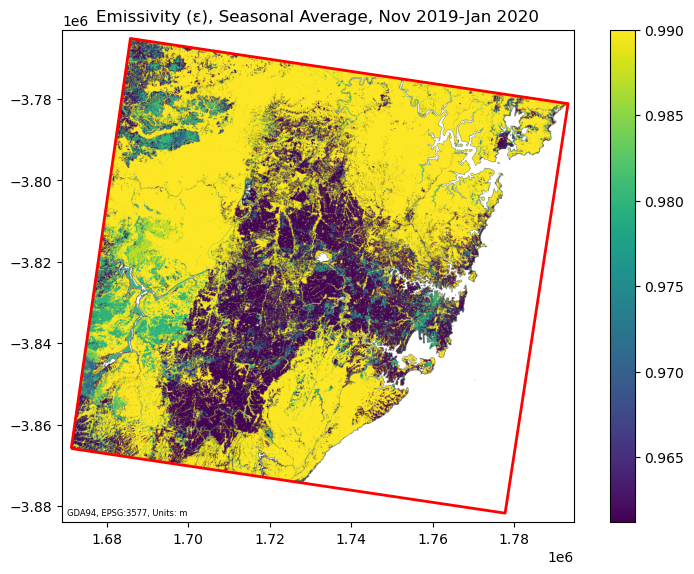

In [116]:
# Visualisation
out_path = Path('out/DAY/E_median_sm.tif')
bbox_shp = "bbox_sm.gpkg"

with rasterio.open(out_path) as src:
    arr = src.read(1)
    fig, ax = plt.subplots(figsize=(8,6))
    im = show(src, ax=ax, cmap='viridis')
    cbar = fig.colorbar(im.get_images()[0], ax=ax)
    plt.title("Emissivity (ε), Seasonal Average, Nov 2019-Jan 2020")

    bbox_gdf = gpd.read_file(bbox_shp)
    if bbox_gdf.crs != src.crs:
        bbox_gdf = bbox_gdf.to_crs(src.crs)
    
    bbox_gdf.boundary.plot(ax = ax, edgecolor= "red", linewidth = 2)

    ax.annotate(
        "GDA94, EPSG:3577, Units: m",
        xy=(0.01, 0.01),
        xycoords='axes fraction',
        fontsize=6,
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'),
        zorder=1000
    )

    plt.tight_layout()
    plt.show()



arr[arr == -9999] = np.nan

# Atmospheric Correction

Wanted bands 10 [10600 - 11190], 11 [11500 - 12510]

$$L_{\lambda} = {\tau}{\epsilon}{L_T} + L_{u} + {\tau}(1 - \epsilon)L_{d}$$

Where:
- $L_T = $ surface-leaving radiance → ${B_i}{T_s}$
- $\tau = $ transmissivity
- $L_u = $ upwelling/atmospheric path radiance
- $L_d = $ downwelling/sky radiance
- $L_{\lambda} = $ TOA Radiance (as derived previously)
- ${\epsilon} = $ pixel-wise emissivity (as derived previously)

Explanation:
- To derive LST we need to solve the radiative transfer equation which is presented at the sensor above
- To get the input parameters $\tau$, $L_u$, $L_d$ we need to use an atmospheric correction model
  - What we have derived so far is TOA values at the sensor
    - To get surface values we need to correct for the atmosphere
  - NASA's Atmospheric Correction Parameter Calculator was the standard for getting the parameters, but was shut down earlier this year
    - Under the hood it used MODTRAN and NCEP atmospheric profiles to derive the parameters
      - MODTRAN is paid software and too expensive for a student like me
  - Instead we can use open-source libRadtran
- Use libRadtran we need to input atmospheric profiles
- We could use the standard "midlat summer" profile
  - However these are essentially a mean for the whole summer period
  - Since we are looking at day vs night, we'd be using the same atmospheric profile for both day and night scenes which would obviously be inaccurate
- It would be better to get atmospheric profiles per-scene, matched to date and time
  - We can do this with ERA5 or NCEP
    - ERA5 has higher spatiotemporal resolution (1-hourly) and good global coverage, vs NCEP (6-hourly)
      - Thus since we are trying to match specific day-night times ERA5 is the go
- The parameters we need for libRadtran are:
  - z(km), p(mb), T(K), air(cm-3), o3(cm-3), o2(cm-3), h2o(cm-3), co2(cm-3), no2(cm-3)
  - We can derive what we need from ERA5 which gives pressure (p), temp (K), specific humidity (q), geopotential (z) and ozone mass mixing ratio (o3)
  - We just have to assume ideal gas laws

Steps:
- Extract datetime of Landsat scene and match to ERA5 reanalysis
- Build atmospheric profile per scene
- Use atmospheric profile in libRadtran to get:
  - edn
  - upwelling
  - transmissivity
- Solve for L_d:
  - $\frac{edn}{\pi}$

## Atmospheric Parameters Derivation

In [72]:
root = Path('data/LANDSAT') # Do both day and night
scenes = collect_scenes(root)

wanted_bands = [10] # Only need band 10
band_wavelengths = {
    10: (10600, 11190), # See Landsat 8 user's guide
    # 11: (11500, 12510)
}


### Build Atmospheric Profile per Landsat Scene

In [73]:
# Helper function to get Landsat spatiotemporal from the metadata MTL file

def get_spacetime_params(mtl_path, buffer_deg = 0.0, debug = False):
    target_keys = {
        "DATE_ACQUIRED": None, # Acquisition date
        "SCENE_CENTER_TIME": None, # Time passed over centre of scene
        "CORNER_UL_LAT_PRODUCT": None, # upper left coords
        "CORNER_UL_LON_PRODUCT": None,
        "CORNER_UR_LAT_PRODUCT": None, # upper right coords
        "CORNER_UR_LON_PRODUCT": None,
        "CORNER_LL_LAT_PRODUCT": None, # lower left coords
        "CORNER_LL_LON_PRODUCT": None,
        "CORNER_LR_LAT_PRODUCT": None, # lower right coords
        "CORNER_LR_LON_PRODUCT": None,
    }

    # Line parser
    kv_re = re.compile(r'^\s*([A-Z0-9_]+)\s*=\s*(.+?)\s*$')

    with open(mtl_path) as f:
        for line in f:
            m = kv_re.match(line)
            if not m:
                continue
            key, val = m.group(1), m.group(2).strip()
            if key not in target_keys:
                continue
            if len(val) >= 2 and val[0] in "\"'" and val[-1] == val[0]:
                if debug:
                    print(f"Removing quotes around value: {val}")
                val = val[1:-1]
            target_keys[key] = val

    missing = [k for k, v in target_keys.items() if v is None]
    if missing:
        raise ValueError(f"Missing required MTL keys: {missing}")

    if debug:
        print("Parsed MTL keys:")
        for k, v in target_keys.items():
            print(f"    {k:25s} = {v}")

    # Get temporal params for ERA5
    date = target_keys["DATE_ACQUIRED"]
    time = target_keys["SCENE_CENTER_TIME"]
    t_clean = time.strip().rstrip("Z")

    m = re.match(r"(\d{2}):(\d{2})", t_clean)
    if not m:
        raise ValueError(f"Unrecognised time format: {time}")
    hour, minute = map(int, m.groups())
    if debug:
        print(f"Stripping hour value = {hour} and minute value = {minute}")

    if minute >= 30:
        hour += 1
        if debug:
            print(f"Minute value > 30, rounding to nearest hour: {hour}")
    if hour == 24:
        if debug:
            print(f"Hour value = 24, rolling over to 0")
        hour = 0
        rollover = True
    else:
        rollover = False

    if rollover:
        if debug:
            print("Rollover from 24:00 to 0:00 detected --> Modifying day by +1")
        date = (datetime.strptime(date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")

    # Get spatial params for ERA5
    lats = [
        float(target_keys["CORNER_UL_LAT_PRODUCT"]),
        float(target_keys["CORNER_UR_LAT_PRODUCT"]),
        float(target_keys["CORNER_LL_LAT_PRODUCT"]),
        float(target_keys["CORNER_LR_LAT_PRODUCT"]),
    ]
    lons = [
        float(target_keys["CORNER_UL_LON_PRODUCT"]),
        float(target_keys["CORNER_UR_LON_PRODUCT"]),
        float(target_keys["CORNER_LL_LON_PRODUCT"]),
        float(target_keys["CORNER_LR_LON_PRODUCT"]),
    ]

    north = max(lats) + buffer_deg
    south = min(lats) - buffer_deg
    west  = min(lons) - buffer_deg
    east  = max(lons) + buffer_deg

    if debug:
        print("Extracting latitudes:", lats)
        print("Extracting longitudes:", lons)
        print(f"Extracting bounding box (N, W, S, E): {north:.6f}, {west:.6f}, {south:.6f}, {east:.6f}")

    area = [north, west, south, east]

    return date, hour, area

In [74]:
def retrieve_era5(
    date,
    hour,
    area,
    out_path,
    variables = None,
    pressure_levels = None,
    dataset = "reanalysis-era5-pressure-levels",
    product_type = "reanalysis", fmt = "netcdf",
    debug = False
):

    if variables is None:
        variables = [
            "temperature",
            "specific_humidity",
            "geopotential",
            "ozone_mass_mixing_ratio"
        ]
        if debug:
            print("No manual input; automatically choosing ERA5 variables")
    
    if pressure_levels is None:
        pressure_levels = [
            "1000","975","950","925","900","875","850","825","800","775",
            "750","700","650","600","550","500","450","400","350","300",
            "250","225","200","175","150","125","100","70","50","30","20","10"
        ]
        if debug:
            print("No manual input; automatically choosing ERA5 pressure levels")

    year, month, day = date[:4], date[5:7], date[8:10]    
    c = Client()
    c.retrieve(
        dataset,
        {
            "product_type": product_type,
            "format": fmt,
            "variable": variables,
            "pressure_level": pressure_levels,
            "year": year,
            "month": month,
            "day": day,
            "time": hour,
            "area": area,
        },
        out_path
    )

    print(f"Downloaded atmospheric data to {out_path}")
    return out_path

In [75]:
def build_atm_prof(
    era5_data,
    area,
    out_path,
    show_stats = False,
    debug = False
):
    # Constants
    k_B = 1.380649e-23 # Boltzmann
    N_A = 6.02214076e23 # Avogadro
    g0 = 9.80665 # Gravitational constant
    R_d = 287.05 # Dry air gas constant

    # Molecular weights
    m_air = 0.0289652
    m_h2o = 0.01801528
    m_o3 =  0.048
    eps = m_h2o / m_air # ~0.622

    chi_o2 =  0.20946 # 02 volume mixing ratio
    chi_co2 = 420e-6 # C02 volume mixing ratio, approximately 420 ppm for modern scenes
    chi_no2 = 0.5e-9 # Small placeholder

    if debug:
        print("Loading ERA5 data...")
        print("Slicing to the appropriate area...")
    ds = xr.load_dataset(era5_data)

    # Subset by area again to only get the data full within (i.e not edge / overlappers)
    ds_subset = ds.sel(latitude=slice(area[0], area[2]), longitude=slice(area[1], area[3]))

    if show_stats:
        for var in ds_subset.data_vars:
            v = ds_subset[var]
            print(f"\nVariable: {var}")
            print(f"  min:  {float(v.min().values):.4g}")
            print(f"  max:  {float(v.max().values):.4g}")
            print(f"  mean: {float(v.mean().values):.4g}")
            print(f"  std:  {float(v.std().values):.4g}")

    if debug:
        print("Calculating median atmospheric profile...")
    median = ds_subset.median(dim = ["latitude", "longitude"], skipna = True, keep_attrs=True)

    # Strip the time dimension so that we can build the dataframe later on (and its not needed)
    median = median.mean(dim = "valid_time", skipna=True)
    median = median.sortby("pressure_level")

    p_hPa = median["pressure_level"].values.astype(float)
    p_Pa = p_hPa * 100
    T = median["t"].values
    q = median["q"].values
    phi = median["z"].values
    mmro3 = median["o3"].values

    # Height derivation
    z_m = phi / g0
    z_km = z_m / 1000.0

    # Air number density derivation
    n_air_m3 = p_Pa / (k_B * T)
    air_cm3 = n_air_m3 / 1e6

    # Water vapour number density derivation
    r = q / (1.0 - q)
    e = p_Pa * r / (r + eps)
    n_h2o_m3 = e / (k_B * T)
    h2o_cm3  = n_h2o_m3 / 1e6

    # Ozone number density derivation
    R_m      = R_d * (1 + r/eps) / (1 + r)
    rho_air  = p_Pa / (R_m * T)
    conc_O3  = mmro3 * rho_air
    mol_O3   = conc_O3 / m_o3
    n_O3_m3  = mol_O3 * N_A
    o3_cm3   = n_O3_m3 / 1e6

    # O2 and CO2 number density derivation
    o2_cm3   = chi_o2  * air_cm3
    co2_cm3  = chi_co2 * air_cm3

    # NO2 number density derivation
    no2_cm3  = chi_no2 * air_cm3

    atm_profile = pd.DataFrame({
        "z(km)"     : z_km,
        "p(mb)"     : p_hPa, # 1 mb = 1hPa
        "T(K)"      : T,
        "air(cm-3)" : air_cm3,
        "o3(cm-3)"  : o3_cm3,
        #"o2(cm-3)"  : o2_cm3,
        "h2o(cm-3)" : h2o_cm3,
        #"co2(cm-3)" : co2_cm3,
        #"no2(cm-3)" : no2_cm3,
    })

    atm_profile = atm_profile.sort_values("z(km)", ascending = False).reset_index(drop=True) # libRadtran expects descending order
    
    # Need to manually insert commented header lines for libRadtran compatability
    header_lines = [
        "# " + " ".join(atm_profile.columns),
    ]

    if debug:
        print("Saving atmospheric profile to .dat")

    with open(out_path, "w", newline="\n") as f:
        for line in header_lines:
            f.write(line + "\n")
        atm_profile.to_csv(
            f,
            sep=" ",
            index = False,
            header = False,
            float_format = "%.6e",
            lineterminator = "\n"
        )

In [76]:
for sid, bmap in sorted(scenes.items()):
    in_dir = next(iter(bmap.values())).parent
    era5_out_path = in_dir / f"{sid}_ATM.nc"
    atm_prof_out_path = in_dir / f"{sid}_ATM_PROF.dat"
    print(f"The input image is: {in_dir}")

    # Locate MTL file
    mtl_file = list(in_dir.glob("*_MTL.txt"))
    
    if not mtl_file:
        print(f"No MTL found for {in_dir}")
    
    mtl_path = mtl_file[0]

    # Extract spatiotemporal characteristics
    date, hour, area = get_spacetime_params(mtl_path, debug = True)

    # Download ERA5 data
    era5_data = retrieve_era5(date, hour, area, out_path = era5_out_path, debug = True)

    # Constructure median atmospheric profile for the Landsat scene
    atm_profile = build_atm_prof(era5_data, area, out_path = atm_prof_out_path, debug = True)

The input image is: data\LANDSAT\NIGHT\LC08_L1GT_208160_20191226_20200824_02_T2
Removing quotes around value: "12:30:11.3322960Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2019-12-26
    SCENE_CENTER_TIME         = 12:30:11.3322960Z
    CORNER_UL_LAT_PRODUCT     = -33.51673
    CORNER_UL_LON_PRODUCT     = 150.03931
    CORNER_UR_LAT_PRODUCT     = -33.55141
    CORNER_UR_LON_PRODUCT     = 152.57449
    CORNER_LL_LAT_PRODUCT     = -35.65108
    CORNER_LL_LON_PRODUCT     = 149.96256
    CORNER_LR_LAT_PRODUCT     = -35.68862
    CORNER_LR_LON_PRODUCT     = 152.56344
Stripping hour value = 12 and minute value = 30
Minute value > 30, rounding to nearest hour: 13
Extracting latitudes: [-33.51673, -33.55141, -35.65108, -35.68862]
Extracting longitudes: [150.03931, 152.57449, 149.96256, 152.56344]
Extracting bounding box (N, W, S, E): -33.516730, 149.962560, -35.688620, 152.574490
No manual input; automatically choosing ERA5 variables
No manual input; automatically choosing ERA5 pressure

2025-11-21 11:06:15,090 INFO Request ID is 9c125070-13ba-4dee-b667-f0d8d2adca87
2025-11-21 11:06:15,458 INFO status has been updated to accepted
2025-11-21 11:06:24,918 INFO status has been updated to running
2025-11-21 11:06:30,306 INFO status has been updated to successful


cdeebd2f422930f9472c12c58e5ecd54.nc:   0%|          | 0.00/85.9k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\NIGHT\LC08_L1GT_208160_20191226_20200824_02_T2\LC08_L1GT_208160_20191226_20200824_02_T2_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\NIGHT\LC08_L1GT_208161_20191226_20200824_02_T2
Removing quotes around value: "12:30:35.2826400Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2019-12-26
    SCENE_CENTER_TIME         = 12:30:35.2826400Z
    CORNER_UL_LAT_PRODUCT     = -32.07932
    CORNER_UL_LON_PRODUCT     = 149.66410
    CORNER_UR_LAT_PRODUCT     = -32.12048
    CORNER_UR_LON_PRODUCT     = 152.15830
    CORNER_LL_LAT_PRODUCT     = -34.21338
    CORNER_LL_LON_PRODUCT     = 149.58225
    CORNER_LR_LAT_PRODUCT     = -34.25800
    CORNER_LR_LON_PRODUCT     = 152.13760
Stripping hour value = 12 and minute value = 30
Minute value > 30, rounding to nearest hour: 13
Extracting latitudes: [-32.07932, -32.12048, -34.21338, 

2025-11-21 11:06:43,802 INFO Request ID is 4c40598e-fbdb-4d58-930b-765d6b71ed08
2025-11-21 11:06:44,135 INFO status has been updated to accepted
2025-11-21 11:06:53,646 INFO status has been updated to running
2025-11-21 11:07:06,951 INFO status has been updated to successful


544ad43af1b197f444b9e0882ee689b3.nc:   0%|          | 0.00/86.1k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\NIGHT\LC08_L1GT_208161_20191226_20200824_02_T2\LC08_L1GT_208161_20191226_20200824_02_T2_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\NIGHT\LC08_L1GT_209160_20191217_20201023_02_T2
Removing quotes around value: "12:36:24.4279540Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2019-12-17
    SCENE_CENTER_TIME         = 12:36:24.4279540Z
    CORNER_UL_LAT_PRODUCT     = -33.58942
    CORNER_UL_LON_PRODUCT     = 148.46885
    CORNER_UR_LAT_PRODUCT     = -33.53553
    CORNER_UR_LON_PRODUCT     = 150.93535
    CORNER_LL_LAT_PRODUCT     = -35.66917
    CORNER_LL_LON_PRODUCT     = 148.50598
    CORNER_LR_LAT_PRODUCT     = -35.61096
    CORNER_LR_LON_PRODUCT     = 151.03455
Stripping hour value = 12 and minute value = 36
Minute value > 30, rounding to nearest hour: 13
Extracting latitudes: [-33.58942, -33.53553, -35.66917, 

2025-11-21 11:07:16,244 INFO Request ID is ed9445cf-77d4-4f2a-bd7f-6bc3ed63d684
2025-11-21 11:07:16,578 INFO status has been updated to accepted
2025-11-21 11:07:31,414 INFO status has been updated to successful


877b36440489477fc4f506bebc8fa317.nc:   0%|          | 0.00/86.1k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\NIGHT\LC08_L1GT_209160_20191217_20201023_02_T2\LC08_L1GT_209160_20191217_20201023_02_T2_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\NIGHT\LC08_L1GT_209161_20191115_20200825_02_T2
Removing quotes around value: "12:36:51.8209170Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2019-11-15
    SCENE_CENTER_TIME         = 12:36:51.8209170Z
    CORNER_UL_LAT_PRODUCT     = -32.14831
    CORNER_UL_LON_PRODUCT     = 148.09538
    CORNER_UR_LAT_PRODUCT     = -32.10399
    CORNER_UR_LON_PRODUCT     = 150.52319
    CORNER_LL_LAT_PRODUCT     = -34.23156
    CORNER_LL_LON_PRODUCT     = 148.12162
    CORNER_LR_LAT_PRODUCT     = -34.18361
    CORNER_LR_LON_PRODUCT     = 150.60741
Stripping hour value = 12 and minute value = 36
Minute value > 30, rounding to nearest hour: 13
Extracting latitudes: [-32.14831, -32.10399, -34.23156, 

2025-11-21 11:07:36,878 INFO Request ID is 0b2c2fc3-4bf3-4114-a7ba-fdd15d788905
2025-11-21 11:07:37,197 INFO status has been updated to accepted
2025-11-21 11:07:59,924 INFO status has been updated to successful


30b648ae61d6153a4297b7749286ea79.nc:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\NIGHT\LC08_L1GT_209161_20191115_20200825_02_T2\LC08_L1GT_209161_20191115_20200825_02_T2_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\NIGHT\LC08_L1GT_209161_20191217_20201023_02_T2
Removing quotes around value: "12:36:48.3782970Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2019-12-17
    SCENE_CENTER_TIME         = 12:36:48.3782970Z
    CORNER_UL_LAT_PRODUCT     = -32.14831
    CORNER_UL_LON_PRODUCT     = 148.09538
    CORNER_UR_LAT_PRODUCT     = -32.10399
    CORNER_UR_LON_PRODUCT     = 150.52319
    CORNER_LL_LAT_PRODUCT     = -34.23156
    CORNER_LL_LON_PRODUCT     = 148.12162
    CORNER_LR_LAT_PRODUCT     = -34.18361
    CORNER_LR_LON_PRODUCT     = 150.60741
Stripping hour value = 12 and minute value = 36
Minute value > 30, rounding to nearest hour: 13
Extracting latitudes: [-32.14831, -32.10399, -34.23156, 

2025-11-21 11:08:05,447 INFO Request ID is 2848a187-8455-4e9e-98ab-0aafabcfbe74
2025-11-21 11:08:05,786 INFO status has been updated to accepted
2025-11-21 11:08:28,529 INFO status has been updated to successful


f3ff5d9df174d0a3419988a75ea61c73.nc:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\NIGHT\LC08_L1GT_209161_20191217_20201023_02_T2\LC08_L1GT_209161_20191217_20201023_02_T2_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1
Removing quotes around value: "23:44:05.7558700Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2019-11-06
    SCENE_CENTER_TIME         = 23:44:05.7558700Z
    CORNER_UL_LAT_PRODUCT     = -32.11364
    CORNER_UL_LON_PRODUCT     = 150.57819
    CORNER_UR_LAT_PRODUCT     = -32.13681
    CORNER_UR_LON_PRODUCT     = 153.02651
    CORNER_LL_LAT_PRODUCT     = -34.20890
    CORNER_LL_LON_PRODUCT     = 150.51986
    CORNER_LR_LAT_PRODUCT     = -34.23398
    CORNER_LR_LON_PRODUCT     = 153.02715
Stripping hour value = 23 and minute value = 44
Minute value > 30, rounding to nearest hour: 24
Hour value = 24, rolling over to 0
Rollover from 24:00 to 

2025-11-21 11:08:33,779 INFO Request ID is 85bafd20-5a86-40db-a2ad-4c3ac7fb5b08
2025-11-21 11:08:34,105 INFO status has been updated to accepted
2025-11-21 11:08:43,518 INFO status has been updated to running
2025-11-21 11:08:48,937 INFO status has been updated to successful


3fba03fa9308ec25b8496e44040c2977.nc:   0%|          | 0.00/86.8k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\DAY\LC08_L1TP_089083_20200109_20200823_02_T1
Removing quotes around value: "23:43:54.7811890Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2020-01-09
    SCENE_CENTER_TIME         = 23:43:54.7811890Z
    CORNER_UL_LAT_PRODUCT     = -32.11406
    CORNER_UL_LON_PRODUCT     = 150.60043
    CORNER_UR_LAT_PRODUCT     = -32.13680
    CORNER_UR_LON_PRODUCT     = 153.04877
    CORNER_LL_LAT_PRODUCT     = -34.20936
    CORNER_LL_LON_PRODUCT     = 150.54263
    CORNER_LR_LAT_PRODUCT     = -34.23397
    CORNER_LR_LON_PRODUCT     = 153.04995
Stripping hour value = 23 and minute value = 43
Minute value > 30, rounding to nearest hour: 24
Hour value = 24, rolling over to 0
Rollover from 24:00 to 0:

2025-11-21 11:08:54,471 INFO Request ID is fd5d1d31-acca-4cf3-b33e-c762681f63d0
2025-11-21 11:08:54,811 INFO status has been updated to accepted
2025-11-21 11:09:04,236 INFO status has been updated to running
2025-11-21 11:09:09,620 INFO status has been updated to successful


c3f1e37b74ca84bc682b1fac404a31ae.nc:   0%|          | 0.00/86.6k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\DAY\LC08_L1TP_089083_20200109_20200823_02_T1\LC08_L1TP_089083_20200109_20200823_02_T1_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\DAY\LC08_L1TP_089083_20200125_20200823_02_T1
Removing quotes around value: "23:43:50.6340860Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2020-01-25
    SCENE_CENTER_TIME         = 23:43:50.6340860Z
    CORNER_UL_LAT_PRODUCT     = -32.11412
    CORNER_UL_LON_PRODUCT     = 150.60361
    CORNER_UR_LAT_PRODUCT     = -32.13680
    CORNER_UR_LON_PRODUCT     = 153.04877
    CORNER_LL_LAT_PRODUCT     = -34.20942
    CORNER_LL_LON_PRODUCT     = 150.54589
    CORNER_LR_LAT_PRODUCT     = -34.23397
    CORNER_LR_LON_PRODUCT     = 153.04995
Stripping hour value = 23 and minute value = 43
Minute value > 30, rounding to nearest hour: 24
Hour value = 24, rolling over to 0
Rollover from 24:00 to 0:

2025-11-21 11:09:15,355 INFO Request ID is fe2ca1e6-5d64-40df-8d58-873d69e9dbd4
2025-11-21 11:09:15,690 INFO status has been updated to accepted
2025-11-21 11:09:21,422 INFO status has been updated to running
2025-11-21 11:09:25,116 INFO status has been updated to successful


f04f8a9892ac55c33b6a71a399d17e71.nc:   0%|          | 0.00/86.6k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\DAY\LC08_L1TP_089083_20200125_20200823_02_T1\LC08_L1TP_089083_20200125_20200823_02_T1_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\DAY\LC08_L1TP_089084_20191106_20200825_02_T1
Removing quotes around value: "23:44:29.7062130Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2019-11-06
    SCENE_CENTER_TIME         = 23:44:29.7062130Z
    CORNER_UL_LAT_PRODUCT     = -33.54408
    CORNER_UL_LON_PRODUCT     = 150.16757
    CORNER_UR_LAT_PRODUCT     = -33.57599
    CORNER_UR_LON_PRODUCT     = 152.64872
    CORNER_LL_LAT_PRODUCT     = -35.63544
    CORNER_LL_LON_PRODUCT     = 150.09563
    CORNER_LR_LAT_PRODUCT     = -35.66993
    CORNER_LR_LON_PRODUCT     = 152.63979
Stripping hour value = 23 and minute value = 44
Minute value > 30, rounding to nearest hour: 24
Hour value = 24, rolling over to 0
Rollover from 24:00 to 0:

2025-11-21 11:09:34,326 INFO Request ID is d53f408c-d649-4b3f-bb77-dd021410ddfe
2025-11-21 11:09:34,666 INFO status has been updated to accepted
2025-11-21 11:09:49,446 INFO status has been updated to successful


4f38f8c7e02e6042255f4e49e67c1ad0.nc:   0%|          | 0.00/86.8k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\DAY\LC08_L1TP_089084_20191106_20200825_02_T1\LC08_L1TP_089084_20191106_20200825_02_T1_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\DAY\LC08_L1TP_090083_20191113_20200825_02_T1
Removing quotes around value: "23:50:15.1368020Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2019-11-13
    SCENE_CENTER_TIME         = 23:50:15.1368020Z
    CORNER_UL_LAT_PRODUCT     = -32.10830
    CORNER_UL_LON_PRODUCT     = 149.07212
    CORNER_UR_LAT_PRODUCT     = -32.16031
    CORNER_UR_LON_PRODUCT     = 151.49303
    CORNER_LL_LAT_PRODUCT     = -34.18423
    CORNER_LL_LON_PRODUCT     = 148.97835
    CORNER_LR_LAT_PRODUCT     = -34.24050
    CORNER_LR_LON_PRODUCT     = 151.45696
Stripping hour value = 23 and minute value = 50
Minute value > 30, rounding to nearest hour: 24
Hour value = 24, rolling over to 0
Rollover from 24:00 to 0:

2025-11-21 11:09:58,913 INFO Request ID is fcbcec43-abaf-474b-ad2c-fe8a9d11912a
2025-11-21 11:09:59,249 INFO status has been updated to accepted
2025-11-21 11:10:14,079 INFO status has been updated to successful


f10ef6457f5220f25d45458bd66ad454.nc:   0%|          | 0.00/86.8k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\DAY\LC08_L1TP_090083_20191113_20200825_02_T1\LC08_L1TP_090083_20191113_20200825_02_T1_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\DAY\LC08_L1TP_090083_20191215_20201022_02_T1
Removing quotes around value: "23:50:11.5796909Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2019-12-15
    SCENE_CENTER_TIME         = 23:50:11.5796909Z
    CORNER_UL_LAT_PRODUCT     = -32.10849
    CORNER_UL_LON_PRODUCT     = 149.07846
    CORNER_UR_LAT_PRODUCT     = -32.16039
    CORNER_UR_LON_PRODUCT     = 151.49939
    CORNER_LL_LAT_PRODUCT     = -34.18444
    CORNER_LL_LON_PRODUCT     = 148.98485
    CORNER_LR_LAT_PRODUCT     = -34.24059
    CORNER_LR_LON_PRODUCT     = 151.46347
Stripping hour value = 23 and minute value = 50
Minute value > 30, rounding to nearest hour: 24
Hour value = 24, rolling over to 0
Rollover from 24:00 to 0:

2025-11-21 11:10:20,399 INFO Request ID is 438d5d98-3ac8-4a12-b9ce-1cda3426aeaf
2025-11-21 11:10:20,890 INFO status has been updated to accepted
2025-11-21 11:10:30,353 INFO status has been updated to running
2025-11-21 11:10:35,732 INFO status has been updated to successful


2ba805399dc1798aa05a977c31be655.nc:   0%|          | 0.00/86.8k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\DAY\LC08_L1TP_090083_20191215_20201022_02_T1\LC08_L1TP_090083_20191215_20201022_02_T1_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\DAY\LC08_L1TP_090083_20191231_20200824_02_T1
Removing quotes around value: "23:50:07.1967950Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2019-12-31
    SCENE_CENTER_TIME         = 23:50:07.1967950Z
    CORNER_UL_LAT_PRODUCT     = -32.10869
    CORNER_UL_LON_PRODUCT     = 149.08481
    CORNER_UR_LAT_PRODUCT     = -32.16050
    CORNER_UR_LON_PRODUCT     = 151.50894
    CORNER_LL_LAT_PRODUCT     = -34.18195
    CORNER_LL_LON_PRODUCT     = 148.99147
    CORNER_LR_LAT_PRODUCT     = -34.23800
    CORNER_LR_LON_PRODUCT     = 151.47329
Stripping hour value = 23 and minute value = 50
Minute value > 30, rounding to nearest hour: 24
Hour value = 24, rolling over to 0
Rollover from 24:00 to 0:

2025-11-21 11:10:41,267 INFO Request ID is 4f1de7d1-4af5-4328-9456-403e0007fcdf
2025-11-21 11:10:41,582 INFO status has been updated to accepted
2025-11-21 11:10:56,387 INFO status has been updated to successful


1b01e26fe9299ae778c372a0a3b11703.nc:   0%|          | 0.00/86.5k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\DAY\LC08_L1TP_090083_20191231_20200824_02_T1\LC08_L1TP_090083_20191231_20200824_02_T1_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\DAY\LC08_L1TP_090083_20200201_20200823_02_T1
Removing quotes around value: "23:49:58.7879320Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2020-02-01
    SCENE_CENTER_TIME         = 23:49:58.7879320Z
    CORNER_UL_LAT_PRODUCT     = -32.10889
    CORNER_UL_LON_PRODUCT     = 149.09115
    CORNER_UR_LAT_PRODUCT     = -32.16054
    CORNER_UR_LON_PRODUCT     = 151.51212
    CORNER_LL_LAT_PRODUCT     = -34.18217
    CORNER_LL_LON_PRODUCT     = 148.99796
    CORNER_LR_LAT_PRODUCT     = -34.23804
    CORNER_LR_LON_PRODUCT     = 151.47655
Stripping hour value = 23 and minute value = 49
Minute value > 30, rounding to nearest hour: 24
Hour value = 24, rolling over to 0
Rollover from 24:00 to 0:

2025-11-21 11:11:01,704 INFO Request ID is 69bc250b-e541-4380-891e-e06ca2fd76c8
2025-11-21 11:11:02,048 INFO status has been updated to accepted
2025-11-21 11:11:16,859 INFO status has been updated to successful


96b98749268392bbe2f96df52f7df5d0.nc:   0%|          | 0.00/87.1k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\DAY\LC08_L1TP_090083_20200201_20200823_02_T1\LC08_L1TP_090083_20200201_20200823_02_T1_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\DAY\LC08_L1TP_090083_20200217_20200823_02_T1
Removing quotes around value: "23:49:55.2935970Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2020-02-17
    SCENE_CENTER_TIME         = 23:49:55.2935970Z
    CORNER_UL_LAT_PRODUCT     = -32.10869
    CORNER_UL_LON_PRODUCT     = 149.08481
    CORNER_UR_LAT_PRODUCT     = -32.16046
    CORNER_UR_LON_PRODUCT     = 151.50576
    CORNER_LL_LAT_PRODUCT     = -34.18465
    CORNER_LL_LON_PRODUCT     = 148.99134
    CORNER_LR_LAT_PRODUCT     = -34.24067
    CORNER_LR_LON_PRODUCT     = 151.46999
Stripping hour value = 23 and minute value = 49
Minute value > 30, rounding to nearest hour: 24
Hour value = 24, rolling over to 0
Rollover from 24:00 to 0:

2025-11-21 11:11:22,406 INFO Request ID is edb45c03-3d13-4fd3-986f-bdec8fc4d147
2025-11-21 11:11:22,730 INFO status has been updated to accepted
2025-11-21 11:11:32,144 INFO status has been updated to running
2025-11-21 11:11:37,532 INFO status has been updated to successful


8d3cba0cddef34633cb65273e752614f.nc:   0%|          | 0.00/86.3k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\DAY\LC08_L1TP_090083_20200217_20200823_02_T1\LC08_L1TP_090083_20200217_20200823_02_T1_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\DAY\LC08_L1TP_090084_20191113_20200825_02_T1
Removing quotes around value: "23:50:39.0871450Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2019-11-13
    SCENE_CENTER_TIME         = 23:50:39.0871450Z
    CORNER_UL_LAT_PRODUCT     = -33.56151
    CORNER_UL_LON_PRODUCT     = 148.53947
    CORNER_UR_LAT_PRODUCT     = -33.50352
    CORNER_UR_LON_PRODUCT     = 151.08879
    CORNER_LL_LAT_PRODUCT     = -35.71150
    CORNER_LL_LON_PRODUCT     = 148.57973
    CORNER_LR_LAT_PRODUCT     = -35.64870
    CORNER_LR_LON_PRODUCT     = 151.19539
Stripping hour value = 23 and minute value = 50
Minute value > 30, rounding to nearest hour: 24
Hour value = 24, rolling over to 0
Rollover from 24:00 to 0:

2025-11-21 11:11:46,694 INFO Request ID is e7372f48-5452-4d08-9a09-7e679d7e01bf
2025-11-21 11:11:47,008 INFO status has been updated to accepted
2025-11-21 11:11:56,409 INFO status has been updated to running
2025-11-21 11:12:01,788 INFO status has been updated to accepted
2025-11-21 11:12:21,411 INFO status has been updated to successful


18435be18bfcefe58f0594b8335fe141.nc:   0%|          | 0.00/87.0k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\DAY\LC08_L1TP_090084_20191113_20200825_02_T1\LC08_L1TP_090084_20191113_20200825_02_T1_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat
The input image is: data\LANDSAT\DAY\LC08_L1TP_090084_20191215_20201022_02_T1
Removing quotes around value: "23:50:35.5300339Z"
Parsed MTL keys:
    DATE_ACQUIRED             = 2019-12-15
    SCENE_CENTER_TIME         = 23:50:35.5300339Z
    CORNER_UL_LAT_PRODUCT     = -33.56143
    CORNER_UL_LON_PRODUCT     = 148.54593
    CORNER_UR_LAT_PRODUCT     = -33.50331
    CORNER_UR_LON_PRODUCT     = 151.09523
    CORNER_LL_LAT_PRODUCT     = -35.71411
    CORNER_LL_LON_PRODUCT     = 148.58642
    CORNER_LR_LAT_PRODUCT     = -35.65117
    CORNER_LR_LON_PRODUCT     = 151.20214
Stripping hour value = 23 and minute value = 50
Minute value > 30, rounding to nearest hour: 24
Hour value = 24, rolling over to 0
Rollover from 24:00 to 0:

2025-11-21 11:12:26,892 INFO Request ID is 2080608c-f660-40b4-933b-77269ef81326
2025-11-21 11:12:27,227 INFO status has been updated to accepted
2025-11-21 11:12:42,224 INFO status has been updated to successful


fc46d38e97f25720f42e80d772c1d244.nc:   0%|          | 0.00/86.9k [00:00<?, ?B/s]

Downloaded atmospheric data to data\LANDSAT\DAY\LC08_L1TP_090084_20191215_20201022_02_T1\LC08_L1TP_090084_20191215_20201022_02_T1_ATM.nc
Loading ERA5 data...
Slicing to the appropriate area...
Calculating median atmospheric profile...
Saving atmospheric profile to .dat


- The ERA5 data has been downloaded
- The next function builds the atmospheric profile
- Since the ERA5 dataset has a 30 km resolution, I extract a median atmospheric profile
  - This will be fine since we're looking to derive the approximate from the at-sensor RTE equation

In [77]:
def derive_ld(
    mnt,
    uvspec_path,
    atmosphere_input,
    ld_inp,
    ld_out,
    lambda_min,
    lambda_max,
    source = "thermal",
    azimuth = 0,
    umu = 1.0,
    z = 0,
    debug = False,
):

    # Handle POSIX paths

    print(atmosphere_input)
    print(ld_inp)

    mounted_atmosphere_input = mnt / atmosphere_input
    posix_atm_prof = mounted_atmosphere_input.as_posix()
    if debug:
        print(posix_atm_prof)

    mounted_ld_inp = mnt / ld_inp
    posix_ld_inp = mounted_ld_inp.as_posix()
    if debug:
        print(posix_ld_inp)

    mounted_ld_out = mnt / ld_out
    posix_ld_out = mounted_ld_out.as_posix()
    if debug:
        print(posix_ld_out)

    # Create ld input file

    params = {
        "SOURCE": source,
        "ATM_PROF": posix_atm_prof,
        "UMU": umu,
        "NM_MIN": lambda_min,
        "NM_MAX": lambda_max,
        "AZIMUTH": azimuth,
        "Z": z,
    }

    ld_template = 'libradtran/templates/l_d.INP'

    with open(ld_template, "r") as f:
        template = f.read()
    
    filled = template.format(**params)

    with open(ld_inp, "w") as f:
        f.write(filled)

    if debug:
        print(f"Deriving ld...") 
        print(f"Sending command: {uvspec_path} < {posix_ld_inp} > {posix_ld_out}")
    
    cmd = (
        f"cd /home/samla/libRadtran-2.0.6/bin && "
        f"./uvspec < {posix_ld_inp} > {posix_ld_out}"
        )
    
    subprocess.run(["wsl", "bash", "-lc", cmd], check = True)

    # Post process
    df = pd.read_csv(ld_out, sep=r"\s+", header = None)
    df.columns = ["wavelength_nm", "L_d"]
    df.to_csv(ld_out, index = False)


In [78]:
mnt = '/mnt/c/Users/samla/Desktop/temp/GEOM7001_A1/GEOM7001_A1' # mount point for WSL to access Windows
uvspec_path =  '/home/samla/libRadtran-2.0.6/bin/uvspec'


for sid, bmap in sorted(scenes.items()):

    in_dir = next(iter(bmap.values())).parent
    
    atmosphere_input = in_dir / f"{sid}_ATM_PROF.dat"
    
    for band in wanted_bands:
        lambda_min, lambda_max = band_wavelengths[band]

        ld_inp = in_dir / f"{sid}_B{band}_LD.inp"
        ld_out = in_dir / f"{sid}_B{band}_LD.dat"

        # Derive ld for the scene
        derive_ld(
            mnt = mnt,
            uvspec_path = uvspec_path,
            atmosphere_input = atmosphere_input,
            ld_inp = ld_inp,
            ld_out = ld_out,
            lambda_min = lambda_min,
            lambda_max = lambda_max,
            debug = True,
        )

data\LANDSAT\NIGHT\LC08_L1GT_208160_20191226_20200824_02_T2\LC08_L1GT_208160_20191226_20200824_02_T2_ATM_PROF.dat
data\LANDSAT\NIGHT\LC08_L1GT_208160_20191226_20200824_02_T2\LC08_L1GT_208160_20191226_20200824_02_T2_B10_LD.inp
/mnt/c/Users/samla/Desktop/temp/GEOM7001_A1/GEOM7001_A1/data/LANDSAT/NIGHT/LC08_L1GT_208160_20191226_20200824_02_T2/LC08_L1GT_208160_20191226_20200824_02_T2_ATM_PROF.dat
/mnt/c/Users/samla/Desktop/temp/GEOM7001_A1/GEOM7001_A1/data/LANDSAT/NIGHT/LC08_L1GT_208160_20191226_20200824_02_T2/LC08_L1GT_208160_20191226_20200824_02_T2_B10_LD.inp
/mnt/c/Users/samla/Desktop/temp/GEOM7001_A1/GEOM7001_A1/data/LANDSAT/NIGHT/LC08_L1GT_208160_20191226_20200824_02_T2/LC08_L1GT_208160_20191226_20200824_02_T2_B10_LD.dat
Deriving ld...
Sending command: /home/samla/libRadtran-2.0.6/bin/uvspec < /mnt/c/Users/samla/Desktop/temp/GEOM7001_A1/GEOM7001_A1/data/LANDSAT/NIGHT/LC08_L1GT_208160_20191226_20200824_02_T2/LC08_L1GT_208160_20191226_20200824_02_T2_B10_LD.inp > /mnt/c/Users/samla/Deskt

In [79]:
def derive_lu(
    mnt,
    uvspec_path,
    atmosphere_input,
    lu_inp,
    lu_out,
    lambda_min,
    lambda_max,
    source = 'thermal',
    umu = 1.0,
    azimuth = 0,
    z = 'TOA',
    debug = False,
):

    # Handle POSIX paths

    print(atmosphere_input)
    print(lu_inp)

    mounted_atmosphere_input = mnt / atmosphere_input
    posix_atm_prof = mounted_atmosphere_input.as_posix()
    if debug:
        print(posix_atm_prof)

    mounted_lu_inp = mnt / lu_inp
    posix_lu_inp = mounted_lu_inp.as_posix()
    if debug:
        print(posix_lu_inp)

    mounted_lu_out = mnt / lu_out
    posix_lu_out = mounted_lu_out.as_posix()
    if debug:
        print(posix_lu_out)

    # Create lu input file

    params = {
        "SOURCE": source,
        "ATM_PROF": posix_atm_prof,
        "UMU": umu,
        "AZIMUTH": azimuth,
        "NM_MIN": lambda_min,
        "NM_MAX": lambda_max,
        "Z": z,
    }

    lu_template = 'libradtran/templates/l_u.INP'

    with open(lu_template, "r") as f:
        template = f.read()
    
    filled = template.format(**params)

    with open(lu_inp, "w") as f:
        f.write(filled)


    if debug:
        print(f"Deriving lu...") 
        print(f"Sending command: {uvspec_path} < {posix_lu_inp} > {posix_lu_out}")
    
    cmd = (
        f"cd /home/samla/libRadtran-2.0.6/bin && "
        f"./uvspec < {posix_lu_inp} > {posix_lu_out}"
    )

    subprocess.run(["wsl", "bash", "-lc", cmd], check = True)

    # Post process
    df = pd.read_csv(lu_out, sep=r"\s+", header = None)
    df.columns = ["wavelength_nm", "L_u"]
    df.to_csv(lu_out, index = False)

In [80]:
mnt = '/mnt/c/Users/samla/Desktop/temp/GEOM7001_A1/GEOM7001_A1' # mount point for WSL to access Windows
uvspec_path =  '/home/samla/libRadtran-2.0.6/bin/uvspec'

for sid, bmap in sorted(scenes.items()):

    in_dir = next(iter(bmap.values())).parent
    
    atmosphere_input = in_dir / f"{sid}_ATM_PROF.dat"
    
    for band in wanted_bands:
        lambda_min, lambda_max = band_wavelengths[band]

        lu_inp = in_dir / f"{sid}_B{band}_LU.inp"
        lu_out = in_dir / f"{sid}_B{band}_LU.dat"

        # Derive lu for the scene
        derive_lu(
            mnt = mnt,
            uvspec_path = uvspec_path,
            atmosphere_input = atmosphere_input,
            lu_inp = lu_inp,
            lu_out = lu_out,
            lambda_min = lambda_min,
            lambda_max = lambda_max,
            debug = True,
        )

data\LANDSAT\NIGHT\LC08_L1GT_208160_20191226_20200824_02_T2\LC08_L1GT_208160_20191226_20200824_02_T2_ATM_PROF.dat
data\LANDSAT\NIGHT\LC08_L1GT_208160_20191226_20200824_02_T2\LC08_L1GT_208160_20191226_20200824_02_T2_B10_LU.inp
/mnt/c/Users/samla/Desktop/temp/GEOM7001_A1/GEOM7001_A1/data/LANDSAT/NIGHT/LC08_L1GT_208160_20191226_20200824_02_T2/LC08_L1GT_208160_20191226_20200824_02_T2_ATM_PROF.dat
/mnt/c/Users/samla/Desktop/temp/GEOM7001_A1/GEOM7001_A1/data/LANDSAT/NIGHT/LC08_L1GT_208160_20191226_20200824_02_T2/LC08_L1GT_208160_20191226_20200824_02_T2_B10_LU.inp
/mnt/c/Users/samla/Desktop/temp/GEOM7001_A1/GEOM7001_A1/data/LANDSAT/NIGHT/LC08_L1GT_208160_20191226_20200824_02_T2/LC08_L1GT_208160_20191226_20200824_02_T2_B10_LU.dat
Deriving lu...
Sending command: /home/samla/libRadtran-2.0.6/bin/uvspec < /mnt/c/Users/samla/Desktop/temp/GEOM7001_A1/GEOM7001_A1/data/LANDSAT/NIGHT/LC08_L1GT_208160_20191226_20200824_02_T2/LC08_L1GT_208160_20191226_20200824_02_T2_B10_LU.inp > /mnt/c/Users/samla/Deskt

# Spectral Response (SRF)

- Our simulation of the atmosphere does not include the sensor properties which imperfectly captures radiance
- We need to correct for the sensor using the spectral response, which is essentially how the sensor captures radiance at different
- Additionally $L_d$ and $L_u$ are given by our atmospheric simulation over a range of wavelengths for each band
- The conversion to LST requires that we compress these, so we need to take a band average 
- After this section we should end up with a band-average $L_u$ and $L_d$ that has been weighted for the sensor spectral response for each band

$$
\lambda_i
=
\frac{
\displaystyle \int_{\lambda_{1,i}}^{\lambda_{2,i}} f_i(\lambda)\,\lambda\, d\lambda
}{
\displaystyle \int_{\lambda_{1,i}}^{\lambda_{2,i}} f_i(\lambda)\, d\lambda
} $$

- This equation gives us the effective / representative wavelength for the band 

In [5]:
# Convert it to csv to make everything easier to manage
xlsx_path = 'tirs_srs.xlsx'
csv_path = 'tirs_srs.csv'

# Cleaning
df = pd.read_excel(xlsx_path)
df = df.loc[:, ~df.columns.str.contains(r"^Unnamed")]
df = df.drop(columns=["Relative to RADIANCE"])
df["wavelength [um]"] = df["wavelength [um]"] * 1000.0

rename_map = {
    "wavelength [um]": "wavelength_nm",
    "TIRS1 10.8um band average": "srf_b10",
    "TIRS2 12.0um band average": "srf_b11",
    "stdev(TIRS1 all dets) [%]": "stdev_b10",
    "stdev(TIRS2 all dets) [%]": "stdev_b11"
}

df = df.rename(columns = rename_map)
df.to_csv(csv_path, index = False)

c:\Users\samla\.conda\envs\geospat\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
def effective_band_wavelength(
    srf_input,
    band,
    lambda_col = "wavelength_nm"
):
    srf_band_col = f"srf_b{band}"
    srf_df = pd.read_csv(srf_input)
    lambda_srf = srf_df[lambda_col].to_numpy(dtype=float)
    r = srf_df[srf_band_col].to_numpy(dtype=float)

    num = np.trapz(r * lambda_srf, lambda_srf)
    den = np.trapz(r, lambda_srf)

    if den == 0:
        raise ValueError("SRF integral is zero, check the input")

    effective_band_wavelength = num / den

    return effective_band_wavelength

In [7]:
test = effective_band_wavelength(
    srf_input = 'tirs_srs.csv',
    band = 10
)


# Radiance Aggregation
- The downwelling ($L_d$) and upwelling ($L_u$) radiance components outputted by libRadtran do not have a spatial dimension because they are derived from the atmospheric profile which is scene-level
- They do have a spectral resolution however, meaning that we have L_d and L_u per micrometer (!!) of wavelength
  - Thus we aggregate these because each Landsat band incorporates a range of wavelengths
- It's not as simple as getting a median or average, because the sensor reacts differently to different wavelengths; this is known as the sensor's spectral response (SRF)
  - Thus we need to get radiance values that are aggregated for SRF

In [8]:
def rad_srf_weighter(
    ld_input,
    lu_input,
    srf_input,
    band,
    lambda_col = "wavelength_nm", # I standardised the names across l_d, l_u and srf datasets
    ld_col = 'L_d',
    lu_col = 'L_u',
):

    srf_band_col = f"srf_b{band}"

    # Load srf
    srf_df = pd.read_csv(srf_input)
    lamda_srf = srf_df[lambda_col]
    r = srf_df[srf_band_col].to_numpy(dtype=float)

    # Load ld and lu for the band
    def load(
        path,
        val_col
    ):
        df = pd.read_csv(path)
        df = df[[lambda_col, val_col]].dropna().sort_values(lambda_col)
        lam = df[lambda_col].to_numpy(dtype=float)
        val = df[val_col].to_numpy(dtype=float)
        return lam, val
    
    lamda_ld, ld_val = load(ld_input, ld_col)
    lamda_lu, lu_val = load(lu_input, lu_col)

    # Interpolate

    ld_interp = np.interp(lamda_srf, lamda_ld, ld_val)
    lu_interp = np.interp(lamda_srf, lamda_lu, lu_val)

    # Band average
    num_ld = np.trapz(ld_interp * r, lamda_srf)
    num_lu = np.trapz(lu_interp * r, lamda_srf)
    den = np.trapz(r, lamda_srf)

    ld_band_average = num_ld / den 
    lu_band_average = num_lu / den

    return ld_band_average, lu_band_average

In [9]:
test_ld = 'data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_B10_LD.dat'
test_lu = 'data\LANDSAT\DAY\LC08_L1TP_089083_20191106_20200825_02_T1\LC08_L1TP_089083_20191106_20200825_02_T1_B10_LU.dat'
test_srf = 'tirs_srs.csv'
test_band = 10

ld10, lu10 = rad_srf_weighter(
    ld_input = test_ld,
    lu_input = test_lu,
    srf_input = test_srf,
    band = test_band
)

print(f"The outputted SRF-weighted band-average value for L_d and L_u is: L_d = {ld10}; L_d = {lu10} [W/m^2/sr/nm]")


The outputted SRF-weighted band-average value for L_d and L_u is: L_d = 0.0006110437106158458; L_d = 5.058396259712445e-05 [W/m^2/sr/nm]


In [10]:
h  = 6.62607015e-34   # Planck constant [J*s]
c  = 2.99792458e8     # Speed of light [m/s]
kB = 1.380649e-23     # Boltzmann constant [J/K]

def planck(wavelength_um, temperature_K):
    lam_m = wavelength_um * 1e-6  # µm → m
    c1 = 2 * h * c**2
    c2 = h * c / kB
    B_m = (c1 / lam_m**5) / (np.exp(c2 / (lam_m * temperature_K)) - 1)  # W/(m^2 sr m)
    return B_m * 1e-6  # → W/(m^2 sr µm)

def planck_inverse(wavelength_um, radiance):
    lam_m = wavelength_um * 1e-6  # µm → m
    c1 = 2 * h * c**2
    c2 = h * c / kB

    # Convert radiance to per-metre units for the formula
    L_m = radiance * 1e6  # W/(m^2 sr m)

    # T = c2 / (λ * ln(1 + c1 / (L λ^5)))
    return c2 / (lam_m * np.log(1.0 + c1 / (L_m * lam_m**5)))


In [11]:
# Blackbody test - We're testing our simulation of the atmosphere and the outputted parameters of the radiative transfer equation
# We assume the object under our atmosphere is a blackbody with full absorption (i.e emissivity = 1) with a "known" temperature of 300K
# The radiance that would be reaching our Landsat 8 sensor is ~13.3

K = 300 # Test temp
lam = 11.0 # About the middle of Band 10
e = 1 # Full absorption by the blackbody
tau = 0.9 # About normal for clear sky conditions
ld = ld10 * 1000 # Convert to um
lu = lu10 * 1000 # Convert to um

print(f"The downwelling radiation component is: {ld} [W/m^2/sr/um]")
print(f"The upwelling radiation component is: {lu} [W/m^2/sr/um]")

test = tau * (e * planck(lam, K) + (1 - e) * ld) + lu

print(f"The radiance reaching the sensor is: {test} [W/m^2/sr/um]")

# Quickly test the inverse Planck fx

L_toa = test
B_surface = (L_toa - lu) / tau
T_recover = planck_inverse(lam, B_surface)
print(f"Inverting Planck's law allows us to recover the temperature: {T_recover} K")


The downwelling radiation component is: 0.6110437106158458 [W/m^2/sr/um]
The upwelling radiation component is: 0.05058396259712445 [W/m^2/sr/um]
The radiance reaching the sensor is: 8.666446140041824 [W/m^2/sr/um]
Inverting Planck's law allows us to recover the temperature: 300.0 K


# Transmissivity ($\tau$)

- Can be estimated from water content ($w$) (g/cm^2) / precipitable water ($PW$) ($kg/m^2$) available in the atmospheric profile:

$$PW = \frac{1}{g}\int{q}{dp}$$

Where:
- ${g} = $ gravity
- ${q} = $ specific humidity
- ${p} = $ pressure

For mid latitude summer $\tau$ is a quadratic relationship with coefficients that vary depending on the Landsat 8 band (https://www.mdpi.com/2072-4292/6/10/9829):
| Atmosphere Profile | Water Content Range (w) | Equation                                                                                        |
| ------------------ | ----------------------- | ----------------------------------------------------------------------------------------------- |
| Midlat Summer      | $0.2-3.0$               | $\tau_{B10} = −0.0164w^2 − 0.04203w + 0.9715$ <br> $\tau_{B11} = −0.01218w^2 − 0.07735w + 0.9603$ |
|                    | $3.0-6.0$               | $\tau_{B10} = −0.00168w^2 − 0.1329w + 1.127$ <br> $\tau_{B11} = −0.09186w^2 − 0.2137w + 1.181$    |

For these relationships: $R^2$ $> 0.999$, RMSE $< 0.003$

NOTE: These are specific to Landsat 8/9 TIRS and thus do not need to be band-averaged (weighted for SRF)

In [12]:
def derive_water_content(
    era5_input,
    q_var = 'q',
    p_coord = 'pressure_level',
    vertical_dimension = 'pressure_level',
    debug = False
):
    # Constants
    g = 9.80665
    if debug:
        print(f"Set gravitational constant: {g}")

    if debug:
        print(f"Opening inputted ERA5 dataset...")
    ds = xr.open_dataset(era5_input)
    q = ds[q_var]
    p = ds[p_coord]

    if debug:
        print(f"Converting hPa to Pa")
    p_pa = p * 100 # mb/hPa -> Pa

    # Sort by pressure
    if debug:
        print(f"Sorting values by pressure...")
    q = q.sortby(p_pa)
    p_pa = p_pa.sortby(p_pa)

    # Compute PW using trapezoidal rule along vertical dimension
    axis = q.get_axis_num(vertical_dimension)

    if debug:
        print(f"Solving the precipitable water (PW) equation: (1/g) ∫ q dp...")
    pw_vals = np.trapz(q.values, p_pa.values, axis=axis) / g

    # Build result
    if debug:
        print(f"Building output...")
    out_dims = [d for d in q.dims if d != vertical_dimension]
    out_coords = {k: v for k, v in q.coords.items() if k != vertical_dimension}

    if debug:
        print(f"Building precipitable water (PW) array...")
    pw = xr.DataArray(
        pw_vals,
        dims = out_dims,
        coords = out_coords,
        name = "PW",
        attrs = {
            "long_name" : "Precipitable Water",
            "units": "kg m-2",
            "formula": "PW = (1/g) ∫ q dp"
        }
    )

    if debug:
        print(f"Building water content (w) array...")
    w = pw * 0.1
    w.name = "w"
    w.attrs.update(
        {
            "long_name": "Water content",
            "units": "g cm-2",
            "note": "w = 0.1 * PW",
        }
    )

    return pw, w

In [ ]:
# def derive_tau(
#     w,
#     band,
#     debug = False
# ):
#     w_valid = w.where((w>= 0.2) & (w<= 6.0))

#     c = 0.944228
#     b = -0.052720
#     a = -0.011912

#     tau = a * w_valid ** 2 + b * w_valid + c

#     return tau

In [24]:
def derive_tau(
    w,
    band,
    debug = False
):
    if debug:
        print(f"Checking inputted band for compatibility...")
    if band not in (10, 11):
        raise ValueError("Only bands 10 or 11 are supported for this derivation")
    else:
        if debug:
            print(f"Band compatible!")

    # Coefficients for the tau polynomial(s) per band (see Yu et al, 2014)

    coeff_map = {
        10: {
            "low":  {"a": -0.0164,  "b": -0.04203, "c": 0.9715},  # 0.2–3.0
            "high": {"a": -0.00168,  "b": -0.1329, "c": 1.127},  # 3.0–6.0 (example!)
            },
        11: {
            "low":  {"a": -0.01218, "b": -0.07735, "c": 0.9603},  # 0.2–3.0
            "high": {"a": 0.09186, "b": -0.2137, "c": 1.181},  # 3.0–6.0 (example!)
            },
        }

    # Select coefficients based on band

    band_coeffs = coeff_map[band]

    # Mask low and high range w

    w_low = w.where((w >= 0.2) & (w <= 3.0))
    w_high = w.where((w >= 3.0) & (w <= 6.0))

    if debug:
        print("Computing tau...")

    # Low-range tau derivation via polynomial

    a_low, b_low, c_low = band_coeffs["low"]["a"], band_coeffs["low"]["b"], band_coeffs["low"]["c"]
    tau_low = a_low * w_low**2 + b_low * w_low + c_low

    # High-range tau derivation via polynomial

    a_high, b_high, c_high = band_coeffs["high"]["a"], band_coeffs["high"]["b"], band_coeffs["high"]["c"]
    tau_high = a_high * w_high**2 + b_high * w_high + c_high

    # Combine results
    tau = xr.where(~xr.ufuncs.isnan(tau_low), tau_low, tau_high)

    # Only include values in range
    tau = tau.where((w >= 0.2) & (w <= 6.0))
    
    if debug:
        print("Outputting results...")
    
    # Output tau
    tau.name = f"TAU_B{band}"
    tau.attrs["units"] = "1"
    tau.attrs["long_name"] = f"Transmittance for Band {band}"
    tau.attrs["note"] = (
        "Derivation is polynomial relationship with water content following Yu et al, 2014"
        "Polynomial applied piecewise depending on water content range: [0.2-3.0], [3.0-6.0]"
    )

    if debug:
        print(tau)

    tau = tau.clip(min=0.8, max=1.0)

    return tau

## Resampling Tau
- Transmissivity according to the polynomials is given for the spatial dimensions of the ERA5 data (~30km)
- Thus we need to resample tau to match our Landsat scene
- The next block is a function that completes this using nearest neighbour to interpolate the tau values to 30m spatial resolution

In [25]:
def resample_tau(
    tau_input,
    resample_match,
    out_path,
    x_dim = "longitude",
    y_dim = "latitude",
    input_crs = "EPSG:4326",
    debug = False
):
    tau_data = tau_input.squeeze()
    tau_data = tau_data.rio.write_crs(input_crs, inplace = False)
    tau_data = tau_data.rename({y_dim: "y", x_dim: "x"})
    tau_data = tau_data.rio.set_spatial_dims(x_dim = "x", y_dim = "y")
    
    match_data = rxr.open_rasterio(resample_match).squeeze("band", drop = True)

    if debug:
        print(f"Tau min / max: {float(np.nanmin(tau_data))}, {float(np.nanmax(tau_data))}")
        print(f"Tau CRS: {tau_data.rio.crs}")
        print(f"Match CRS: {match_data.rio.crs}")
        print(f"Tau shape: {tau_data.shape}, dims: {tau_data.dims}")
        print(f"Match shape: {match_data.shape}, dims: {match_data.dims}")
    
    # Resample
    resampled_tau = tau_data.rio.reproject_match(
        match_data,
        resampling = Resampling.nearest
        )

    if debug:
        print(f"Tau resampled min / max: {float(np.nanmin(tau_resampled))}, {float(np.nanmax(tau_resampled))}")
        print(f"Resampled tau shape: {resampled_tau.shape}")

    resampled_tau.rio.to_raster(out_path)

In [27]:
root = Path("data/LANDSAT")
wanted_bands = [10]
scenes = collect_scenes(root)

for sid, bmap in sorted(scenes.items()):

    in_dir = next(iter(bmap.values())).parent
    
    era5_input = in_dir / f"{sid}_ATM.nc"
    pw, w = derive_water_content(era5_input)

    for band in wanted_bands:
        tau = derive_tau(w, band = band)
        tau_out_path = in_dir / f"{sid}_B{band}_TAU.tif"
        resample_match = in_dir / f"{sid}_B{band}_BT.vrt"

        resample_tau(
            tau_input = tau,
            resample_match = resample_match,
            out_path = tau_out_path
        )

# LST Derivation

By inverting the radiative transfer equation and Planck's law, we can finally derive LST from brightness temperature:

$$T_s = \frac{C_1}{\lambda_i\ln(\frac{C_2}{\lambda^5_i(B_i(T_i) - L^u_i - \tau_i(1-\epsilon_i)L^d_i)/\tau_i\epsilon_i} + 1)}$$

Where:
- $T_s$ is the surface temperature
- $C_1$ is 14387.7 $[umK]$
- $C_2$ is 1.19104e8 $[W{um}^{4}m^{-2}sr^{-1}]$
- $L^u_i$ is upwelling radiance component for the band $i$
- $L^d_i$ is downwelling radiance component for the band $i$
- $\tau_i$ is the transmissivity value for the band $i$
- $\epsilon_i$ is the pixel-wise emissivity value for the band $i$
- $B_i(T_i)$ is the radiance value at the sensor


Note: Using the RTE with Band 10 is the most accurate!
- Yu et al
- USGS note known issues with Band 11 calibration / stray-light

In [28]:
h  = 6.62607015e-34   # Planck constant [J*s]
c  = 2.99792458e8     # Speed of light [m/s]
kB = 1.380649e-23     # Boltzmann constant [J/K]

def derive_lst(
    bt,
    epsilon,
    tau,
    L_u,
    L_d,
    wavelength_um
):

    bt = np.asarray(bt, dtype=float)
    epsilon = np.asarray(epsilon, dtype=float)
    tau = np.asarray(tau, dtype = float)

    lam = float(wavelength_um)

    # Convert brightness temp to TOA radiance (B_i(T_i))
    BiTi = planck(lam, bt)

    # Solve RTE for surface radiance
    num = BiTi - L_u - tau * (1 - epsilon) * L_d
    den = tau * epsilon
    B_surface = np.where(den > 0, num / den, np.nan)

    # Invert Planck's law for surface temperature
    T_surface = planck_inverse(wavelength_um, B_surface)

    return T_surface

In [29]:
def build_lst_tif(
    bt_input,
    epsilon_input,
    tau_input,
    qa_input,
    aoi_path,
    out_path,
    wavelength_um,
    L_u,
    L_d,
    to_celsius=False,
    debug=False,
):
    # Load inputs
    bt = rxr.open_rasterio(bt_input, masked = True).squeeze("band", drop = True)
    eps = rxr.open_rasterio(epsilon_input, masked = True).squeeze("band", drop = True)
    tau = rxr.open_rasterio(tau_input, masked = True).squeeze("band", drop = True)
    qa = rxr.open_rasterio(qa_input, masked = False).squeeze(drop=True)

    # Reproject
    eps = eps.rio.reproject_match(bt)
    tau = tau.rio.reproject_match(bt)
    qa = qa.rio.reproject_match(bt)

    # Clip
    gdf = gpd.read_file(aoi_path)
    gdf = gdf.to_crs(bt.rio.crs)
    geom = gdf.geometry

    bt  = bt.rio.clip(geom, gdf.crs, drop=True)
    eps = eps.rio.clip(geom, gdf.crs, drop=True)
    tau = tau.rio.clip(geom, gdf.crs, drop=True)
    qa = qa.rio.clip(geom, gdf.crs, drop=True)

    bt_arr  = bt.values.astype("float64")
    eps_arr = eps.values.astype("float64")
    tau_arr = tau.values.astype("float64")
    qa_arr = qa.values.astype("uint8")

    # Define mask
    mask_arr = (~np.isfinite(bt_arr)|~np.isfinite(eps_arr)|~np.isfinite(tau_arr))

    mask_arr |= (qa_arr != 255)

    # Mask out zeros to avoid division by zero in the RTE
    eps_arr[eps_arr <= 0] = np.nan
    tau_arr[tau_arr <= 0] = np.nan

    # Derive LST in K
    lst_k = derive_lst(
        bt = bt_arr,
        epsilon = eps_arr,
        tau = tau_arr,
        L_u = L_u,
        L_d = L_d,
        wavelength_um = wavelength_um
    )

    # Apply mask
    lst_k[mask_arr] = np.nan

    # Convert to celsius option
    if to_celsius:
        lst = lst_k - 273.15
    else:
        lst = lst_k
    
    # Make data array
    lst_da = xr.DataArray(
        lst.astype("float32"),
        dims = bt.dims,
        coords = bt.coords,
        name = "LST"
    )
    lst_da = lst_da.rio.write_crs(bt.rio.crs, inplace = True)

    nodata_val = -9999.0
    lst_da = lst_da.where(np.isfinite(lst_da), nodata_val).astype("float32")
    lst_da = lst_da.rio.write_nodata(nodata_val, inplace = True)

    # Write tif
    lst_da.rio.to_raster(out_path)


In [30]:
root = Path('data/LANDSAT/DAY')
scenes = collect_scenes(root)
wanted_bands = [10]

bbox = 'bbox_sm.gpkg'
eps_median = 'out/DAY/E_median_sm.tif'
srf_input = 'tirs_srs.csv'

for sid, bmap in sorted(scenes.items()):
    in_dir = next(iter(bmap.values())).parent
    for band in wanted_bands:
        eff_nm = effective_band_wavelength(
            srf_input = srf_input,
            band = band
        )
        eff_um = eff_nm / 1000
        ld_dat = in_dir / f"{sid}_B{band}_LD.dat"
        lu_dat = in_dir / f"{sid}_B{band}_LU.dat"

        ld_agg, lu_agg = rad_srf_weighter(
            ld_dat,
            lu_dat,
            srf_input=srf_input,
            band=band
        )

        L_d = ld_agg * 1000.0
        L_u = lu_agg * 1000.0

        bt  = in_dir / f"{sid}_B{band}_BT.vrt"
        tau = in_dir / f"{sid}_B{band}_TAU.tif"
        qa = in_dir / f"{sid}_QA.tif"

        out_path = f"out/DAY/{sid}_B{band}_LSTC.tif"

        build_lst_tif(
            bt_input = bt,
            epsilon_input = eps_median,
            tau_input = tau,
            qa_input = qa,
            aoi_path = bbox,
            out_path = out_path,
            wavelength_um = eff_um,
            L_u = L_u,
            L_d = L_d,
            to_celsius = True,
            debug = True,
        )
        
        print(f"-> {out_path}")


-> out/DAY/LC08_L1TP_089083_20191106_20200825_02_T1_B10_LSTC.tif
-> out/DAY/LC08_L1TP_089083_20200109_20200823_02_T1_B10_LSTC.tif
-> out/DAY/LC08_L1TP_089083_20200125_20200823_02_T1_B10_LSTC.tif
-> out/DAY/LC08_L1TP_089084_20191106_20200825_02_T1_B10_LSTC.tif
-> out/DAY/LC08_L1TP_090083_20191113_20200825_02_T1_B10_LSTC.tif
-> out/DAY/LC08_L1TP_090083_20191215_20201022_02_T1_B10_LSTC.tif
-> out/DAY/LC08_L1TP_090083_20191231_20200824_02_T1_B10_LSTC.tif
-> out/DAY/LC08_L1TP_090083_20200201_20200823_02_T1_B10_LSTC.tif
-> out/DAY/LC08_L1TP_090083_20200217_20200823_02_T1_B10_LSTC.tif
-> out/DAY/LC08_L1TP_090084_20191113_20200825_02_T1_B10_LSTC.tif
-> out/DAY/LC08_L1TP_090084_20191215_20201022_02_T1_B10_LSTC.tif


## Night
- The only difference is we need to input the emissivity from the daytime mosaick

In [31]:
root = Path('data/LANDSAT/NIGHT')
scenes = collect_scenes(root)
wanted_bands = [10]

bbox = 'bbox_sm.gpkg'
eps_median = 'out/DAY/E_median_sm.tif'
srf_input = 'tirs_srs.csv'

for sid, bmap in sorted(scenes.items()):
    in_dir = next(iter(bmap.values())).parent
    for band in wanted_bands:
        eff_nm = effective_band_wavelength(
            srf_input = srf_input,
            band = band
        )
        eff_um = eff_nm / 1000
        ld_dat = in_dir / f"{sid}_B{band}_LD.dat"
        lu_dat = in_dir / f"{sid}_B{band}_LU.dat"

        ld_agg, lu_agg = rad_srf_weighter(
            ld_dat,
            lu_dat,
            srf_input=srf_input,
            band=band
        )

        L_d = ld_agg * 1000.0
        L_u = lu_agg * 1000.0

        bt  = in_dir / f"{sid}_B{band}_BT.vrt"
        tau = in_dir / f"{sid}_B{band}_TAU.tif"
        qa = in_dir / f"{sid}_QA.tif"

        out_path = f"out/NIGHT/{sid}_B{band}_LSTC.tif"

        build_lst_tif(
            bt_input = bt,
            epsilon_input = eps_median,
            tau_input = tau,
            qa_input = qa,
            aoi_path = bbox,
            out_path = out_path,
            wavelength_um = eff_um,
            L_u = L_u,
            L_d = L_d,
            to_celsius = True,
            debug = True,
        )

        print(f"-> {out_path}")

-> out/NIGHT/LC08_L1GT_208160_20191226_20200824_02_T2_B10_LSTC.tif
-> out/NIGHT/LC08_L1GT_208161_20191226_20200824_02_T2_B10_LSTC.tif
-> out/NIGHT/LC08_L1GT_209160_20191217_20201023_02_T2_B10_LSTC.tif
-> out/NIGHT/LC08_L1GT_209161_20191115_20200825_02_T2_B10_LSTC.tif
-> out/NIGHT/LC08_L1GT_209161_20191217_20201023_02_T2_B10_LSTC.tif
